In [101]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from Solver import nummodel, nummodel_jac, explicit_solve, implicit_solve
from NeuralNet import *
from timeit import default_timer



In [102]:
def permeability_ref(q):
    return q**2
f = (10*yy**4 - 20*yy**3 + 12*yy**2 - 2*yy)
q_sol = -yy*(yy - 1)


# Training a quadratic function

In [103]:
nn_save_name = "quadratic.nn"
N_train = 4000
x_train = np.linspace(-1,1, N_train).reshape((N_train, 1))
y_train = permeability_ref(x_train)
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 2000
batch_size = 64

layers = 2
width  = 20
model = FNN(ind, outd, layers, width) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(model, nn_save_name)
        


Epoch :  0  Epoch time :  0.07681959700130392  Train L2 Loss :  150394.78872680664
Epoch :  100  Epoch time :  0.05276360899733845  Train L2 Loss :  20.805169753730297
Epoch :  200  Epoch time :  0.04941356199560687  Train L2 Loss :  5.98793887719512
Epoch :  300  Epoch time :  0.05295360300806351  Train L2 Loss :  5.468865856528282
Epoch :  400  Epoch time :  0.04962845498812385  Train L2 Loss :  5.17790487036109
Epoch :  500  Epoch time :  0.05295415400178172  Train L2 Loss :  5.063431857153773
Epoch :  600  Epoch time :  0.05417246400611475  Train L2 Loss :  4.9453056287020445
Epoch :  700  Epoch time :  0.050148100999649614  Train L2 Loss :  4.921465087682009
Epoch :  800  Epoch time :  0.04975960199953988  Train L2 Loss :  4.8981317058205605
Epoch :  900  Epoch time :  0.052676457999041304  Train L2 Loss :  4.883428398519754
Epoch :  1000  Epoch time :  0.050253701003384776  Train L2 Loss :  4.879632074385881
Epoch :  1100  Epoch time :  0.05366958299418911  Train L2 Loss :  4.876

# Testing on the quadratic function

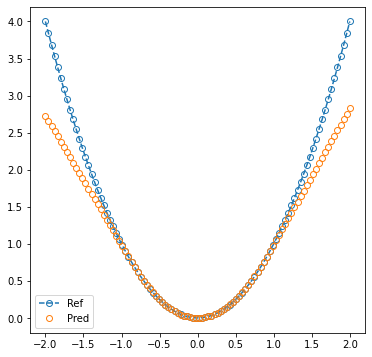

In [104]:
N_test = 100
x_test = np.linspace(-2,2, N_test).reshape((N_test, 1))
y_test = permeability_ref(x_test)
y_pred = model(torch.from_numpy(x_test.astype(np.float32))).detach().numpy()

fig, ax = plt.subplots(1,figsize=(6,6))
ax.plot(x_test,  y_test, "--o", fillstyle = "none", label="Ref")
ax.plot(x_test,  y_pred, "o",   fillstyle = "none", label="Pred")
ax.legend()

In [108]:
Ny = 100
L = 1.0
yy, dy = np.linspace(0, L, Ny), L/(Ny - 1)


def permeability(q):
    
    permeability = model(torch.from_numpy(q.reshape((q.size,1)).astype(np.float32))).detach().numpy().flatten()
    
    
    permeability = scipy.ndimage.gaussian_filter1d(permeability, 5)
    
    error = permeability - q**2
    id_e = np.argmax(np.fabs(error))
    
    print("L2 error is ",   np.linalg.norm(error), 
          "Linf error is ", error[id_e],  " q = ", q[id_e])
    
    return np.fabs(permeability)








yy = np.linspace(0, L, Ny)
MODEL = "imp_nummodel"


if MODEL == "exp_nummodel":

    exp_model = lambda q, yy, res : nummodel(permeability, q, yy, res)
    yy, t_data, q_data = explicit_solve(exp_model, f, dt = 1.0e-4, Nt = 10000, save_every = 1, L = L)

elif MODEL == "imp_nummodel":
    
    imp_model = lambda q, yy, dt, res, V : nummodel_jac(permeability, q, yy, dt, res, V)  
    yy, t_data, q_data = implicit_solve(imp_model, f, dt = 1.0e-2, Nt = 10000, save_every = 1, L = L)
       
else:
    print("ERROR")


 



L2 error is  0.007800390243601152 Linf error is  0.0007839687168598175  q =  0.0
1 max q 0.0012487650032445975
L2 error is  0.008490159945589144 Linf error is  0.0011760749091377666  q =  -0.0009968822302694972
2 max q 0.002497706562391604
L2 error is  0.010239790439102236 Linf error is  0.001552171393867599  q =  -0.0019919369081783907
3 max q 0.003746411484109256
L2 error is  0.011024796000502768 Linf error is  0.001551606496847315  q =  -0.002955593953005631
4 max q 0.004993652295397249
L2 error is  0.0118295102814784 Linf error is  0.0014820654255142977  q =  -0.00373310466842661
5 max q 0.006238796553453571
L2 error is  0.011934663976147302 Linf error is  0.0014116666629180967  q =  -0.00045810684395168274
6 max q 0.0074831331826091755
L2 error is  0.011253706413686296 Linf error is  0.001390116415156066  q =  -0.00054622613183676
7 max q 0.00872789770220591
L2 error is  0.010396086738984478 Linf error is  0.001368495353511886  q =  -0.0006335084530712605
8 max q 0.009973564562932

L2 error is  0.0068934540070484905 Linf error is  -0.001149855104657387  q =  -0.06794084606063172
77 max q 0.0913634943584013
L2 error is  0.006597045624753301 Linf error is  -0.0010944615514793038  q =  -0.06866246465325526
78 max q 0.09234044146093
L2 error is  0.006340229526936227 Linf error is  0.0010862810087111695  q =  -0.007153282121804324
79 max q 0.09330954540971184
L2 error is  0.006093220336962898 Linf error is  0.001176525617025614  q =  -0.007251368489073301
80 max q 0.09427086870669255
L2 error is  0.00587604777350058 Linf error is  0.0012645709334165177  q =  -0.007344800284030894
81 max q 0.09522447756554381
L2 error is  0.005703209774468774 Linf error is  0.0013504356908233357  q =  -0.0074336832087138
82 max q 0.09617044258437422
L2 error is  0.005570384755683149 Linf error is  0.0014341432937282927  q =  -0.007518155041063032
83 max q 0.09710883497915151
L2 error is  0.005478401809377821 Linf error is  0.00151572192623815  q =  -0.007598377456135566
84 max q 0.0980

L2 error is  0.01622586001013184 Linf error is  0.003929172910815885  q =  0.011110042070175767
150 max q 0.14559016214556664
L2 error is  0.01635007037069989 Linf error is  0.003964605793473823  q =  0.011372065164313869
151 max q 0.146126589498595
L2 error is  0.016470423744806253 Linf error is  0.003998598232210098  q =  0.011637078867710341
152 max q 0.14665782458688495
L2 error is  0.016589668072228447 Linf error is  0.004031953779081506  q =  0.011904988779849373
153 max q 0.1471838815897805
L2 error is  0.016707887250716546 Linf error is  0.00406468324156587  q =  0.01217577182809608
154 max q 0.1477047765475642
L2 error is  0.01682514222142189 Linf error is  0.004096792786252154  q =  0.01244940431575832
155 max q 0.14822052727959314
L2 error is  0.01693061978676877 Linf error is  0.004125322853460606  q =  0.01272585989077526
156 max q 0.14873115403038784
L2 error is  0.01703907610628601 Linf error is  0.00415466941845184  q =  0.01300559791532217
157 max q 0.1492366772179135


L2 error is  0.027612473523812592 Linf error is  0.005432099429756162  q =  0.004766377771077363
328 max q 0.19212271931225572
L2 error is  0.02757857324491584 Linf error is  0.005406313243938442  q =  0.005220232791652177
329 max q 0.19225643249477012
L2 error is  0.02760968429440495 Linf error is  0.005405667271048496  q =  0.005673189410182128
330 max q 0.1923896729279902
L2 error is  0.027640846894839345 Linf error is  0.00540431404169198  q =  0.006125637659631743
331 max q 0.19252248399554897
L2 error is  0.027672034096085495 Linf error is  0.005402281205068042  q =  0.006577598334738618
332 max q 0.19265490810682462
L2 error is  0.02772803345840086 Linf error is  0.005409155890173601  q =  0.00702909252290589
333 max q 0.19278698407849315
L2 error is  0.027806791021524006 Linf error is  0.0054240187135516146  q =  0.007481491993781984
334 max q 0.19291874734204756
L2 error is  0.027884240568732586 Linf error is  0.005437499240588399  q =  0.007935869985626575
335 max q 0.1930502

414 max q 0.20221735764983226
L2 error is  0.030621798283090723 Linf error is  0.005523501787891968  q =  0.02215870641473923
415 max q 0.2023174598634107
L2 error is  0.03055488090080923 Linf error is  0.005494039902146471  q =  0.022584390842059262
416 max q 0.20241702959800345
L2 error is  0.030488471215566085 Linf error is  0.0054647258310374985  q =  0.023010928167322448
417 max q 0.20251608990975237
L2 error is  0.03041870724094443 Linf error is  0.005436907505352445  q =  0.0029211744415253635
418 max q 0.2026146675284806
L2 error is  0.03034311245850836 Linf error is  0.005413979734858184  q =  0.0033401798606666746
419 max q 0.20271279105932624
L2 error is  0.030268249778376406 Linf error is  0.005391281723990417  q =  0.0037580421739241343
420 max q 0.20281049105916318
L2 error is  0.03019408546122302 Linf error is  0.005368779813722016  q =  0.0041748972832011955
421 max q 0.2029077987160118
L2 error is  0.030120656819686273 Linf error is  0.005346424666588591  q =  0.004590

541 max q 0.21301655751502227
L2 error is  0.028459651785689703 Linf error is  0.005157120799781785  q =  0.01047231963197045
542 max q 0.21308887875257687
L2 error is  0.02845509751225557 Linf error is  0.005162186504986756  q =  0.01084220217520061
543 max q 0.21316118676104073
L2 error is  0.02849367516520874 Linf error is  0.005188126507595864  q =  0.011212275346789518
544 max q 0.21323347912524757
L2 error is  0.028533042625928616 Linf error is  0.005213466204677753  q =  0.011579210797827274
545 max q 0.2133057516088669
L2 error is  0.0285722177015063 Linf error is  0.005237809844505314  q =  0.011943217227387271
546 max q 0.21337799790271916
L2 error is  0.02861122226498045 Linf error is  0.005261208686904245  q =  0.012304534157251289
547 max q 0.21345021170157774
L2 error is  0.02864995087187386 Linf error is  0.0052836996208772856  q =  0.012663369399073863
548 max q 0.21352238483212543
L2 error is  0.028688358071296566 Linf error is  0.005305325256581484  q =  0.01301990123

L2 error is  0.02768544446919937 Linf error is  0.005163148081390048  q =  0.01292463431143899
607 max q 0.2174582534782168
L2 error is  0.027714194104555903 Linf error is  0.005182323504924827  q =  0.013252168513930183
608 max q 0.21752160137001533
L2 error is  0.027742592880245377 Linf error is  0.005200813347785287  q =  0.013578031185170907
609 max q 0.2175848641049433
L2 error is  0.027770678555934382 Linf error is  0.005218647069384355  q =  0.013902318702393692
610 max q 0.21764803164808955
L2 error is  0.027798420960860014 Linf error is  0.005235855156869858  q =  0.014225114720399265
611 max q 0.21771109414600373
L2 error is  0.02782580624597164 Linf error is  0.005252464861808646  q =  0.014546494165563747
612 max q 0.21777404089853167
L2 error is  0.027852834914781098 Linf error is  0.0052685076309522605  q =  0.014866524923368304
613 max q 0.21783686135196467
L2 error is  0.027879498464497443 Linf error is  0.005283995785763568  q =  0.015185269877183175
614 max q 0.217899

672 max q 0.2212376285870675
L2 error is  0.02670279850163287 Linf error is  0.005064605229061045  q =  0.01402823205197323
673 max q 0.22129271428034533
L2 error is  0.026726673323522455 Linf error is  0.005079911843045889  q =  0.014323369029871809
674 max q 0.2213477158935002
L2 error is  0.02675025258424989 Linf error is  0.005094726747213344  q =  0.014617404161423226
675 max q 0.22140262393264637
L2 error is  0.026773505325004828 Linf error is  0.005109070576146263  q =  0.014910382138430163
676 max q 0.22145742814938574
L2 error is  0.02679645438030726 Linf error is  0.005122955610685857  q =  0.01520234305440234
677 max q 0.22151211908538543
L2 error is  0.026819073879380227 Linf error is  0.0051364076589292575  q =  0.015493323030258254
678 max q 0.22156668606591548
L2 error is  0.026835578103100662 Linf error is  0.005146608313233914  q =  0.015783353960796543
679 max q 0.22162111970422513
L2 error is  0.026829571714206142 Linf error is  0.005145862099143712  q =  0.016072934

738 max q 0.22456490550873925
L2 error is  0.025575424442409653 Linf error is  0.004859835341387613  q =  0.013642485098729888
739 max q 0.22461279617562507
L2 error is  0.025595558453548356 Linf error is  0.004874109492758558  q =  0.013911506955417124
740 max q 0.2246606261685332
L2 error is  0.025615478354669128 Linf error is  0.004887955362955371  q =  0.014179640320290796
741 max q 0.2247083871490982
L2 error is  0.025635124285812303 Linf error is  0.004901390275182765  q =  0.014446915303873402
742 max q 0.22475607029647027
L2 error is  0.025654510102622614 Linf error is  0.0049144277973970476  q =  0.014713360693049723
743 max q 0.22480366680647026
L2 error is  0.025673659766857718 Linf error is  0.004927088959288759  q =  0.014979002713077567
744 max q 0.22485116793059615
L2 error is  0.025692609112272582 Linf error is  0.004939380373382384  q =  0.015243865030016335
745 max q 0.2248985653230477
L2 error is  0.02568942325267286 Linf error is  0.004940218040056007  q =  0.015507

813 max q 0.22782440846731553
L2 error is  0.024493617527832558 Linf error is  0.004676102233220041  q =  0.014103544751454047
814 max q 0.22786545278370154
L2 error is  0.024509222411914205 Linf error is  0.004688068615003692  q =  0.014343542681885427
815 max q 0.2279064264064626
L2 error is  0.02452466226283495 Linf error is  0.004699711424005049  q =  0.014582925638380463
816 max q 0.2279473222799897
L2 error is  0.024538331850217508 Linf error is  0.00471020601939431  q =  0.014821706180711897
817 max q 0.2279881326799082
L2 error is  0.024532472975922058 Linf error is  0.0047099337201141345  q =  0.01506003603124966
818 max q 0.2280288503041809
L2 error is  0.02452666883677791 Linf error is  0.004709737187007709  q =  0.015299649340296706
819 max q 0.22806946823269364
L2 error is  0.024520853591683378 Linf error is  0.0047096005502529886  q =  0.015540323136665425
820 max q 0.22810997926644708
L2 error is  0.024515108332445693 Linf error is  0.004709503557132677  q =  0.015781868

882 max q 0.23039187366020414
L2 error is  0.023222597450229917 Linf error is  0.004331851120061254  q =  0.030596718627451416
883 max q 0.23042703924937283
L2 error is  0.023235746171190414 Linf error is  0.0043412599243434205  q =  0.030793206438786754
884 max q 0.23046219184393704
L2 error is  0.023248791114616866 Linf error is  0.004350379586522843  q =  0.03098816235452584
885 max q 0.23049732878467355
L2 error is  0.02326166775740283 Linf error is  0.00435920995721087  q =  0.03118169217273334
886 max q 0.23053244615652455
L2 error is  0.02327444245846692 Linf error is  0.004367776625005882  q =  0.031373889437551185
887 max q 0.2305675401284651
L2 error is  0.023287036629700452 Linf error is  0.004376079240078422  q =  0.03156484304228312
888 max q 0.23060260581884406
L2 error is  0.023299553950903534 Linf error is  0.0043841357618594565  q =  0.03175462991874092
889 max q 0.23063763916050867
L2 error is  0.023311916627020684 Linf error is  0.004395058922845979  q =  0.013143776

1040 max q 0.23505482875401107
L2 error is  0.02122928356271157 Linf error is  0.0038411474567553706  q =  0.025046609916598447
1041 max q 0.23507907094476288
L2 error is  0.021221917149502084 Linf error is  0.0038402611128474998  q =  0.02522773076605162
1042 max q 0.23510330372510352
L2 error is  0.021214404152602995 Linf error is  0.0038391779827925804  q =  0.02540786836396971
1043 max q 0.23512752895469527
L2 error is  0.021206719887833646 Linf error is  0.003837895240409319  q =  0.02558709870393315
1044 max q 0.2351517485151532
L2 error is  0.021195197617953385 Linf error is  0.0038346552206574075  q =  0.02576549093467554
1045 max q 0.23517596429907422
L2 error is  0.021183522997511257 Linf error is  0.003831269545774716  q =  0.025943157215435796
1046 max q 0.23520017754362166
L2 error is  0.021171759833520293 Linf error is  0.0038277715157041437  q =  0.02612014345937596
1047 max q 0.2352243891847011
L2 error is  0.02116019159074337 Linf error is  0.0038243963231116736  q =  

1135 max q 0.23720527454519746
L2 error is  0.020417787016866962 Linf error is  0.003640177486450176  q =  0.022288002640105352
1136 max q 0.23722476868278994
L2 error is  0.020397643629072305 Linf error is  0.0036324381406829527  q =  0.02245004525114189
1137 max q 0.23724422601076936
L2 error is  0.02037763947964396 Linf error is  0.0036247154770135907  q =  0.02261178306694592
1138 max q 0.23726364934460437
L2 error is  0.020357713755846333 Linf error is  0.0036170050292746382  q =  0.022773218400235686
1139 max q 0.23728304153081667
L2 error is  0.02033785298974674 Linf error is  0.0036093038197262265  q =  0.022934351492985564
1140 max q 0.2373024048249849
L2 error is  0.02031806417426637 Linf error is  0.0036016076535081132  q =  0.02309518875593368
1141 max q 0.2373217417511019
L2 error is  0.020298395218328807 Linf error is  0.003593915031686833  q =  0.02325572850715152
1142 max q 0.2373410548802411
L2 error is  0.020288598955804038 Linf error is  0.0035925090923505875  q =  0

1229 max q 0.2389481059121676
L2 error is  0.01982762890202928 Linf error is  0.003604395012348241  q =  0.03440591095629209
1230 max q 0.23896464132619585
L2 error is  0.01981693199318801 Linf error is  0.0035984613481943924  q =  0.03453201916100508
1231 max q 0.23898111487426502
L2 error is  0.019806286320704018 Linf error is  0.003592583852039851  q =  0.03465836972118107
1232 max q 0.23899752674152563
L2 error is  0.01979581659271479 Linf error is  0.00358674857158615  q =  0.034784912889718626
1233 max q 0.2390138778231162
L2 error is  0.019785417900114954 Linf error is  0.003580958838563692  q =  0.03491160552470486
1234 max q 0.2390301686359942
L2 error is  0.019775094228790868 Linf error is  0.0035752083960911016  q =  0.035038409035640705
1235 max q 0.2390463997010556
L2 error is  0.01976483583699095 Linf error is  0.0035694963702465735  q =  0.03516528830177426
1236 max q 0.23906257140380865
L2 error is  0.01975466890206095 Linf error is  0.003563813784237072  q =  0.0352922

1346 max q 0.24067299994756966
L2 error is  0.01879863486471514 Linf error is  0.0033894295446023734  q =  0.030871486678138868
1347 max q 0.2406861245844588
L2 error is  0.018788671599732885 Linf error is  0.0033860639974963164  q =  0.0309704851696809
1348 max q 0.24069920279202678
L2 error is  0.018778762254054147 Linf error is  0.003382715094309286  q =  0.031069499876185663
1349 max q 0.24071223496646235
L2 error is  0.018768868064900728 Linf error is  0.0033793894785299657  q =  0.031168506240059263
1350 max q 0.2407252214635336
L2 error is  0.018759047464068545 Linf error is  0.003376077806596227  q =  0.03126748248642477
1351 max q 0.2407381627437269
L2 error is  0.018749228904912832 Linf error is  0.0033727860114317935  q =  0.03136640855520842
1352 max q 0.24075105940571065
L2 error is  0.0187428604974763 Linf error is  0.003371021653352584  q =  0.03146526670831268
1353 max q 0.24076391223225246
L2 error is  0.018741742384829483 Linf error is  0.0033715739440274136  q =  0.0

1480 max q 0.2422048803480347
L2 error is  0.017989964581730123 Linf error is  0.0031615631362573895  q =  0.027209461898148345
1481 max q 0.24221546460041962
L2 error is  0.01798876673642265 Linf error is  0.003163791421715551  q =  0.027281670741839528
1482 max q 0.2422260190779026
L2 error is  0.01798652926595239 Linf error is  0.0031654771016261136  q =  0.02735372502856849
1483 max q 0.24223654312061707
L2 error is  0.017984019490328434 Linf error is  0.003167023077036072  q =  0.027425649548449133
1484 max q 0.24224703585078505
L2 error is  0.017981523909317662 Linf error is  0.0031685468549620182  q =  0.027497450870993152
1485 max q 0.24225749630455606
L2 error is  0.017979119241450493 Linf error is  0.003170054046063662  q =  0.02756912954663738
1486 max q 0.24226792407762837
L2 error is  0.01797672130672851 Linf error is  0.003171543316102835  q =  0.02764068539451274
1487 max q 0.24227831846114453
L2 error is  0.017974311386485704 Linf error is  0.00317301423625339  q =  0.0

1603 max q 0.2432752895641336
L2 error is  0.017165932572194398 Linf error is  -0.002872930482132055  q =  -0.0588528560949363
1604 max q 0.24328298422545783
L2 error is  0.017158067677761936 Linf error is  -0.002876021574356822  q =  -0.058869728905031574
1605 max q 0.24329067407956415
L2 error is  0.017150193940635824 Linf error is  -0.0028791060320680732  q =  -0.05888663642920387
1606 max q 0.24329835926803434
L2 error is  0.017142394136456338 Linf error is  -0.002882183598065606  q =  -0.05890357101930918
1607 max q 0.24330604022928695
L2 error is  0.017134571701748005 Linf error is  -0.002885255677755634  q =  -0.058920526796075144
1608 max q 0.24331371726551856
L2 error is  0.017126776509887764 Linf error is  -0.002888323959515282  q =  -0.058937499793760666
1609 max q 0.24332139060643646
L2 error is  0.017119011502300593 Linf error is  -0.002891383461702888  q =  -0.058954488228216535
1610 max q 0.24332906048482833
L2 error is  0.017111263788102068 Linf error is  -0.00289444029

1694 max q 0.24395948153778982
L2 error is  0.016910966873309008 Linf error is  0.0028818988580899445  q =  0.026441045271927144
1695 max q 0.24396634241042905
L2 error is  0.01691006036428708 Linf error is  0.002883541244512748  q =  0.02649359802933547
1696 max q 0.2439731743677225
L2 error is  0.016909251319349314 Linf error is  0.002885170716112434  q =  0.026546075117227674
1697 max q 0.24397997750025707
L2 error is  0.016908447550723446 Linf error is  0.002886788696909127  q =  0.026598476475247518
1698 max q 0.24398675131134184
L2 error is  0.016907645541944093 Linf error is  0.0028883914595001746  q =  0.026650802589730155
1699 max q 0.2439934956830691
L2 error is  0.016906918867732833 Linf error is  0.002889983271225192  q =  0.02670305247268332
1700 max q 0.2440002104399567
L2 error is  0.016903325884350145 Linf error is  0.002888920350768274  q =  0.026755226371829616
1701 max q 0.2440068952162007
L2 error is  0.01689894947926732 Linf error is  0.0028870430449779733  q =  0.

1762 max q 0.24436203972105
L2 error is  0.01668275470060601 Linf error is  0.0028094922541694292  q =  0.030233932876530818
1763 max q 0.24436720363839362
L2 error is  0.016675768608390172 Linf error is  0.002805897837198838  q =  0.03028867151106144
1764 max q 0.2443723542700762
L2 error is  0.016668870286470946 Linf error is  0.002802370241016733  q =  0.030343675900338575
1765 max q 0.24437749207007875
L2 error is  0.016662020443942646 Linf error is  0.0027989006786191435  q =  0.030398901480224786
1766 max q 0.24438261717897183
L2 error is  0.016654858341535926 Linf error is  0.002795294673365216  q =  0.030454306033797268
1767 max q 0.24438773027101449
L2 error is  0.016647322956896703 Linf error is  0.0027915659144082667  q =  0.030509862660658534
1768 max q 0.24439283132654954
L2 error is  0.016639888268524316 Linf error is  0.0027878987796611777  q =  0.030565544262502426
1769 max q 0.24439792082091386
L2 error is  0.016632526017522745 Linf error is  0.0027842859264973407  q =

1874 max q 0.24492453014666515
L2 error is  0.016145174822668095 Linf error is  -0.00265912535236374  q =  -0.054778666586546655
1875 max q 0.2449295741302437
L2 error is  0.01614115109201489 Linf error is  -0.0026619928451201823  q =  -0.05480060172029743
1876 max q 0.2449346169019026
L2 error is  0.01613715363085163 Linf error is  -0.0026648537440647924  q =  -0.054822482804192316
1877 max q 0.24493965823125605
L2 error is  0.01613319826634777 Linf error is  -0.0026677078734213986  q =  -0.05484431042307309
1878 max q 0.244944698357467
L2 error is  0.016129190509221566 Linf error is  -0.002670557665985168  q =  -0.054866086388644604
1879 max q 0.24494973701446762
L2 error is  0.016125231105905396 Linf error is  -0.002673399358599781  q =  -0.05488781306865552
1880 max q 0.2449547746214902
L2 error is  0.016121223343094487 Linf error is  -0.0026762367445635348  q =  -0.054909487165637635
1881 max q 0.24495981097872416
L2 error is  0.016117250101630308 Linf error is  -0.002679070251830

1970 max q 0.2453867609078236
L2 error is  0.016007684220401455 Linf error is  0.002603056118187315  q =  0.03931170810806279
1971 max q 0.24539094520077223
L2 error is  0.016007139593072917 Linf error is  0.002603999033693485  q =  0.03933954138885952
1972 max q 0.24539510934413
L2 error is  0.016006606909807073 Linf error is  0.002604940205709062  q =  0.03936733573484032
1973 max q 0.245399253432424
L2 error is  0.01600609226423282 Linf error is  0.002605877342149717  q =  0.03939509076868529
1974 max q 0.2454033770648019
L2 error is  0.016005623622758754 Linf error is  0.0026068047767955176  q =  0.039422807566309
1975 max q 0.24540748076696275
L2 error is  0.01600514110764967 Linf error is  0.002607731841087727  q =  0.039450485977436944
1976 max q 0.24541156404022701
L2 error is  0.016004693997081303 Linf error is  0.002608656594772752  q =  0.039478127065737986
1977 max q 0.2454156271471347
L2 error is  0.016004285269455854 Linf error is  0.002609575244790903  q =  0.03950573176

L2 error is  0.01591072141130855 Linf error is  0.0025652927596590217  q =  0.041712493404446
2048 max q 0.2456570383935442
L2 error is  0.015909566837230597 Linf error is  0.002564712757430306  q =  0.04174329101288757
2049 max q 0.24565992432140982
L2 error is  0.015908467971323947 Linf error is  0.0025641350465856975  q =  0.04177402734296284
2050 max q 0.24566280118317152
L2 error is  0.015907313613740127 Linf error is  0.002563556426080033  q =  0.041804701829149124
2051 max q 0.24566566885279095
L2 error is  0.015906145241084368 Linf error is  0.002562975424058648  q =  0.041835315502309706
2052 max q 0.24566852751090562
L2 error is  0.015905052227574188 Linf error is  0.0025624001719331867  q =  0.041865865926098284
2053 max q 0.2456713771856357
L2 error is  0.01590386809232002 Linf error is  0.0025618230291171522  q =  0.04189635550644821
2054 max q 0.24567421820274984
L2 error is  0.015902774359449104 Linf error is  0.002561246449762928  q =  0.041926782875315094
2055 max q 0.

2161 max q 0.24595196407249467
L2 error is  0.015632844348823983 Linf error is  -0.002479453956080589  q =  0.20618079925904859
2162 max q 0.24595455506364647
L2 error is  0.015629788906157863 Linf error is  -0.002479284064262885  q =  0.20618494037536497
2163 max q 0.24595714911044034
L2 error is  0.015626736488555826 Linf error is  -0.0024791121086443005  q =  0.20618908543755401
2164 max q 0.24595974609845847
L2 error is  0.01562367814436676 Linf error is  -0.002478938262291487  q =  0.20619323486504876
2165 max q 0.2459623460902187
L2 error is  0.015620657835631612 Linf error is  -0.0024787735882893444  q =  0.2061973883840953
2166 max q 0.24596494886784545
L2 error is  0.015617635128030412 Linf error is  -0.002478603308733826  q =  0.20620154629332182
2167 max q 0.24596755470083584
L2 error is  0.015614630079288724 Linf error is  -0.002478434972053252  q =  0.2062057088297203
2168 max q 0.2459701636890066
L2 error is  0.015611601942208115 Linf error is  -0.0024782609940491446  q =

L2 error is  0.015371122118982715 Linf error is  -0.00247638712055195  q =  -0.05264104883276519
2258 max q 0.24621534200441986
L2 error is  0.015369095139826785 Linf error is  -0.002475388091427042  q =  -0.0526344923479823
2259 max q 0.24621814952104054
L2 error is  0.015367072217167705 Linf error is  -0.00247436069149544  q =  -0.05262736162235078
2260 max q 0.2462209579881053
L2 error is  0.015364971186433662 Linf error is  -0.0024733057801015405  q =  -0.05261970164558959
2261 max q 0.24622376732293016
L2 error is  0.015362872650793035 Linf error is  -0.002472222309662016  q =  -0.05261155146402596
2262 max q 0.24622657705968526
L2 error is  0.015360710755243168 Linf error is  -0.002471111812701954  q =  -0.05260294671777124
2263 max q 0.24622938720882628
L2 error is  0.015358574690928566 Linf error is  -0.002469977105113157  q =  -0.05259391589064234
2264 max q 0.24623219791474146
L2 error is  0.015356406867160728 Linf error is  -0.0024688180162443112  q =  -0.05258448813469039
2

2335 max q 0.24642508430717877
L2 error is  0.015218689181431853 Linf error is  -0.002452158067506538  q =  0.20690251044525337
2336 max q 0.24642762638830348
L2 error is  0.015217289936577854 Linf error is  -0.0024520439111266057  q =  0.20690603361109167
2337 max q 0.24643016209252497
L2 error is  0.015215836605777303 Linf error is  -0.002451922920691789  q =  0.2069095402023438
2338 max q 0.2464326905747293
L2 error is  0.015214421930722487 Linf error is  -0.002451802918113845  q =  0.20691303111716464
2339 max q 0.24643521222018663
L2 error is  0.015213007674346683 Linf error is  -0.0024516868606037287  q =  0.20691650450033483
2340 max q 0.24643772692116622
L2 error is  0.015211670151098448 Linf error is  -0.0024515938784734903  q =  0.20691996157026252
2341 max q 0.24644023448719637
L2 error is  0.015210211244120822 Linf error is  -0.002451467905207491  q =  0.2069234018755179
2342 max q 0.24644273464977454
L2 error is  0.015208826554361328 Linf error is  -0.002451357340476433  q

2451 max q 0.2466583868978152
L2 error is  0.01510054527691598 Linf error is  -0.00244210868527886  q =  0.2072044993468405
2452 max q 0.24665984450215223
L2 error is  0.015100211275252746 Linf error is  -0.0024420350673185418  q =  0.20720639824501907
2453 max q 0.2466612947484052
L2 error is  0.015099872687278089 Linf error is  -0.0024419596156426554  q =  0.20720829270098362
2454 max q 0.24666273795705063
L2 error is  0.015099537284294038 Linf error is  -0.002441886056815057  q =  0.20721018271792907
2455 max q 0.24666417434592053
L2 error is  0.01509921834247082 Linf error is  -0.0024418217100838774  q =  0.20721206797907338
2456 max q 0.2466656038190695
L2 error is  0.015098868855768463 Linf error is  -0.002441748349437514  q =  0.20721394945079374
2457 max q 0.24666702653878045
L2 error is  0.015098537423182025 Linf error is  -0.0024416735110943596  q =  0.20721582733983257
2458 max q 0.2466684427036413
L2 error is  0.015098194207717044 Linf error is  -0.0024416004416741993  q = 

2549 max q 0.24678117285606407
L2 error is  0.015071857034045623 Linf error is  -0.0024356043854752638  q =  0.20737711405375905
2550 max q 0.24678230473571885
L2 error is  0.015071629995239843 Linf error is  -0.0024355445808500534  q =  0.2073787662387359
2551 max q 0.24678343493968108
L2 error is  0.015071385328502628 Linf error is  -0.0024354839219222837  q =  0.2073804163508025
2552 max q 0.2467845638149451
L2 error is  0.015071126553985676 Linf error is  -0.002435418617940381  q =  0.2073820642321806
2553 max q 0.24678569115192628
L2 error is  0.015070932214398095 Linf error is  -0.0024353711781064796  q =  0.20738371026255867
2554 max q 0.24678681715108833
L2 error is  0.015070668449313592 Linf error is  -0.0024353080470444002  q =  0.2073853543750438
2555 max q 0.24678794144648197
L2 error is  0.015070409957075958 Linf error is  -0.002435240392456163  q =  0.20738699654998682
2556 max q 0.2467890642535128
L2 error is  0.015070162276308434 Linf error is  -0.00243517950462184  q =

L2 error is  0.015044213622336239 Linf error is  -0.002431326524243105  q =  0.20749260442029033
2623 max q 0.24686109065270434
L2 error is  0.015043709994901414 Linf error is  -0.0024312574458375813  q =  0.20749413459318788
2624 max q 0.2468621213209791
L2 error is  0.015043273955449953 Linf error is  -0.002431200000861354  q =  0.2074956658573746
2625 max q 0.2468631509801095
L2 error is  0.015042829134974914 Linf error is  -0.00243113914056476  q =  0.20749719785718668
2626 max q 0.24686417954007056
L2 error is  0.015042530812071415 Linf error is  -0.0024310862563107632  q =  0.20749873111186895
2627 max q 0.246865207171582
L2 error is  0.015042425308821446 Linf error is  -0.00243100811930113  q =  0.20750026634142754
2628 max q 0.2468662339285464
L2 error is  0.015042683811696348 Linf error is  -0.0024309563874738774  q =  0.20750180235034424
2629 max q 0.24686725957611513
L2 error is  0.015043303671173666 Linf error is  -0.0024309054395803484  q =  0.20750334023685743
2630 max q 

L2 error is  0.015044087343295555 Linf error is  -0.0025996632939918676  q =  -0.05148957144854411
2755 max q 0.2470050592153115
L2 error is  0.015042542106692506 Linf error is  -0.002599022295422518  q =  -0.05148258342701057
2756 max q 0.24700624924848405
L2 error is  0.01504104775284275 Linf error is  -0.0025983518991325623  q =  -0.05147532876540918
2757 max q 0.2470074396440225
L2 error is  0.015039462232257116 Linf error is  -0.002597657285674284  q =  -0.05146781445546825
2758 max q 0.2470086303402503
L2 error is  0.015037921766293299 Linf error is  -0.0025969363204311  q =  -0.05146003894271342
2759 max q 0.24700982211887645
L2 error is  0.015036357895408893 Linf error is  -0.0025961872029190577  q =  -0.05145200501074772
2760 max q 0.24701101431690214
L2 error is  0.015034732924998285 Linf error is  -0.002595410997506075  q =  -0.05144371814539209
2761 max q 0.2470122068219844
L2 error is  0.015033141075092151 Linf error is  -0.002594609015647604  q =  -0.05143518308669042
276

L2 error is  0.0148225407853421 Linf error is  -0.0024423817310231  q =  -0.0499338015638522
2860 max q 0.2471308389583152
L2 error is  0.014821059570725364 Linf error is  -0.0024413278601856294  q =  -0.049924477531982196
2861 max q 0.24713204024578414
L2 error is  0.01481954738672743 Linf error is  -0.0024403000688161254  q =  -0.04991532918033629
2862 max q 0.24713324150429533
L2 error is  0.014818056446517085 Linf error is  -0.0024392950802280067  q =  -0.04990633959562853
2863 max q 0.2471344429532307
L2 error is  0.014816547827520536 Linf error is  -0.0024383124797441916  q =  -0.04989749355329787
2864 max q 0.2471356445363772
L2 error is  0.014815094645304267 Linf error is  -0.0024373424685488246  q =  -0.049888775361168834
2865 max q 0.2471368459071551
L2 error is  0.014813658371568785 Linf error is  -0.002436389984758709  q =  -0.04988018324028227
2866 max q 0.2471380475061704
L2 error is  0.014812174894055775 Linf error is  -0.0024354520430327035  q =  -0.04987170589053859
28

2950 max q 0.24723613693887023
L2 error is  0.014701003741221439 Linf error is  -0.0024126198968629636  q =  0.20363263486156222
2951 max q 0.24723724305866268
L2 error is  0.0146996118129505 Linf error is  -0.0024125921927876173  q =  0.20363429562933005
2952 max q 0.24723834738052872
L2 error is  0.014698224248035194 Linf error is  -0.002412559828549189  q =  0.2036359540881022
2953 max q 0.2472394500287511
L2 error is  0.01469685930223151 Linf error is  -0.0024125302875658977  q =  0.20363761031856267
2954 max q 0.2472405509678697
L2 error is  0.014695459980533015 Linf error is  -0.0024125033477335883  q =  0.2036392637754286
2955 max q 0.24724164991936753
L2 error is  0.014693748901018626 Linf error is  -0.0024124758061966345  q =  0.20364091574150256
2956 max q 0.24724274733377222
L2 error is  0.014691807548137483 Linf error is  -0.002412450805553884  q =  0.20364256478614878
2957 max q 0.24724384292989113
L2 error is  0.014689803996240924 Linf error is  -0.0024124137019282954  q 

L2 error is  0.014512063360030475 Linf error is  -0.0024086855781540323  q =  0.20385583761851295
3087 max q 0.2473801961453757
L2 error is  0.014511679435470631 Linf error is  -0.00240866348906265  q =  0.20385737328477002
3088 max q 0.24738122007559374
L2 error is  0.014511285693369607 Linf error is  -0.0024086433654930683  q =  0.20385890462331568
3089 max q 0.2473822425664306
L2 error is  0.014510868147241781 Linf error is  -0.0024086104936824684  q =  0.20386043209387164
3090 max q 0.24738326348405026
L2 error is  0.014510538024358038 Linf error is  -0.0024086019721677177  q =  0.2038619553179203
3091 max q 0.24738428276348562
L2 error is  0.014510135703767288 Linf error is  -0.002408573107314453  q =  0.2038634743197133
3092 max q 0.2473853005992257
L2 error is  0.014509768151059204 Linf error is  -0.002408550012687541  q =  0.2038649891889454
3093 max q 0.2473863167919312
L2 error is  0.01450939244022315 Linf error is  -0.0024085289970313603  q =  0.20386650000918172
3094 max q 

3195 max q 0.24747867988007716
L2 error is  0.014473008090318427 Linf error is  -0.0024064729327367904  q =  0.20400011616104552
3196 max q 0.24747946833677034
L2 error is  0.014471864683226556 Linf error is  -0.0024064451539719534  q =  0.2040012533129996
3197 max q 0.24748025454017816
L2 error is  0.014470745726419251 Linf error is  -0.002406423899970145  q =  0.2040023881894808
3198 max q 0.24748103868047716
L2 error is  0.014470017847589148 Linf error is  -0.0024063982575124876  q =  0.20400352143427097
3199 max q 0.2474818209208966
L2 error is  0.014469611727882073 Linf error is  -0.0024063941377811676  q =  0.20400465264091172
3200 max q 0.24748260090184862
L2 error is  0.014469199181354519 Linf error is  -0.0024063746078556783  q =  0.20400578259368546
3201 max q 0.24748337901544148
L2 error is  0.014468726200951864 Linf error is  -0.002406346733884228  q =  0.20400691035040874
3202 max q 0.2474841549804719
L2 error is  0.014468294841482373 Linf error is  -0.0024063293564899543 

3287 max q 0.2475435200396735
L2 error is  0.014423793898637103 Linf error is  -0.0024049568155050938  q =  0.2040936379918482
3288 max q 0.2475441418986124
L2 error is  0.014423162732460219 Linf error is  -0.0024049336866751037  q =  0.2040945304757299
3289 max q 0.24754476215917864
L2 error is  0.014422600529684058 Linf error is  -0.002404917151939606  q =  0.20409542085745966
3290 max q 0.24754538069705453
L2 error is  0.014422014429190166 Linf error is  -0.002404903253656207  q =  0.20409630856784336
3291 max q 0.24754599773957403
L2 error is  0.014421453421313521 Linf error is  -0.002404892142235479  q =  0.2040971939753936
3292 max q 0.2475466129288785
L2 error is  0.01442084916753366 Linf error is  -0.0024048726087236086  q =  0.2040980769990938
3293 max q 0.2475472265343798
L2 error is  0.014420251640565181 Linf error is  -0.0024048558123789254  q =  0.2040989575982775
3294 max q 0.24754783820953716
L2 error is  0.014419685086908808 Linf error is  -0.00240484576150847  q =  0.2

3425 max q 0.2476163222428675
L2 error is  0.014345750156999862 Linf error is  -0.002403136834265289  q =  0.20419972748454868
3426 max q 0.24761677481027675
L2 error is  0.014345254136499428 Linf error is  -0.0024031280686124534  q =  0.20420039926790984
3427 max q 0.24761722650804618
L2 error is  0.014344701718453425 Linf error is  -0.0024031152870872957  q =  0.20420107033755142
3428 max q 0.2476176772422009
L2 error is  0.01434418441238864 Linf error is  -0.002403102191513899  q =  0.204201740636022
3429 max q 0.24761812705967712
L2 error is  0.014343638008165176 Linf error is  -0.0024030847222396567  q =  0.2042024093446261
3430 max q 0.24761857620678882
L2 error is  0.014343115393860285 Linf error is  -0.0024030704540070336  q =  0.20420307676739496
3431 max q 0.24761902449880094
L2 error is  0.014342624612051037 Linf error is  -0.0024030707423571135  q =  0.20420374334426994
3432 max q 0.24761947189597536
L2 error is  0.014342079064560528 Linf error is  -0.002403052005731432  q 

3532 max q 0.24766081874235138
L2 error is  0.01429405042410351 Linf error is  -0.0024019501230367057  q =  0.20426656429393358
3533 max q 0.24766120355094548
L2 error is  0.014293603709494661 Linf error is  -0.002401938942992156  q =  0.20426714787956762
3534 max q 0.24766158795702076
L2 error is  0.014293171674880078 Linf error is  -0.002401931294158416  q =  0.20426773098847284
3535 max q 0.24766197176056934
L2 error is  0.014292733363116202 Linf error is  -0.0024019197054979055  q =  0.2042683135705795
3536 max q 0.24766235516149346
L2 error is  0.014292314361198705 Linf error is  -0.0024019115221027357  q =  0.20426889536768225
3537 max q 0.24766273832137098
L2 error is  0.014291863350210793 Linf error is  -0.0024018994498470198  q =  0.20426947676274937
3538 max q 0.2476631207938173
L2 error is  0.014291419190598892 Linf error is  -0.0024018908601498787  q =  0.20427005756201755
3539 max q 0.24766350276446467
L2 error is  0.014291010112455163 Linf error is  -0.002401882058031886 

3618 max q 0.24769236378097373
L2 error is  0.014258411807173993 Linf error is  -0.0024010944691258765  q =  0.2043146534939176
3619 max q 0.24769271395888567
L2 error is  0.014257445077839834 Linf error is  -0.0024010902299383893  q =  0.20431519011216476
3620 max q 0.24769306397829438
L2 error is  0.01425643408961535 Linf error is  -0.0024010819222976473  q =  0.2043157258892166
3621 max q 0.24769341358214844
L2 error is  0.014255367873805528 Linf error is  -0.002401062193992609  q =  0.20431626106580836
3622 max q 0.24769376267019722
L2 error is  0.014254358059456714 Linf error is  -0.002401060874412754  q =  0.2043167957081828
3623 max q 0.24769411154391338
L2 error is  0.014253347998968671 Linf error is  -0.002401055819284771  q =  0.20431733032405555
3624 max q 0.24769446016620883
L2 error is  0.01425227652158036 Linf error is  -0.0024010394205732366  q =  0.20431786452810852
3625 max q 0.24769480830162427
L2 error is  0.014251191987392135 Linf error is  -0.0024010227910254076  q

L2 error is  0.014070303186878345 Linf error is  -0.0023993740930011234  q =  0.2043968244185153
3755 max q 0.24774222021305747
L2 error is  0.014066300011840793 Linf error is  -0.0023993675657619715  q =  0.2043975283682946
3756 max q 0.24774262903679908
L2 error is  0.014062129914384814 Linf error is  -0.002399343831948633  q =  0.2043982357889606
3757 max q 0.24774303876810647
L2 error is  0.014057870370889312 Linf error is  -0.002399324886359258  q =  0.20439894580732293
3758 max q 0.24774344952183955
L2 error is  0.014053520542006336 Linf error is  -0.0023993038721959667  q =  0.20439965987585867
3759 max q 0.2477438611607392
L2 error is  0.014049053750174413 Linf error is  -0.0023992804695368575  q =  0.20440037721193904
3760 max q 0.24774427369590238
L2 error is  0.014044533414322158 Linf error is  -0.0023992661315815414  q =  0.20440109849392304
3761 max q 0.24774468742254466
L2 error is  0.014039890277534224 Linf error is  -0.0023992455261705806  q =  0.2044018226674773
3762 m

3861 max q 0.24780236363788755
L2 error is  0.013864535016377437 Linf error is  -0.002396132453378448  q =  0.20452133076483597
3862 max q 0.24780323716432096
L2 error is  0.013882427153012375 Linf error is  -0.0023961301791826164  q =  0.20452299184137765
3863 max q 0.24780411699429444
L2 error is  0.013904656852647372 Linf error is  -0.0023961320096143393  q =  0.2045246447246003
3864 max q 0.24780500292356145
L2 error is  0.013932437716126596 Linf error is  -0.002396122974117558  q =  0.20452628924505478
3865 max q 0.24780589445549753
L2 error is  0.013967680834384705 Linf error is  -0.0023961359914113772  q =  0.20452792391440872
3866 max q 0.24780679150220677
L2 error is  0.014012623434101869 Linf error is  -0.002396144537880701  q =  0.20452954764116604
3867 max q 0.24780769385419227
L2 error is  0.01407031385650956 Linf error is  -0.002396155369553822  q =  0.20453115872767422
3868 max q 0.24780860119832407
L2 error is  0.01414472836640685 Linf error is  -0.0023961791705088137  

L2 error is  0.015342246212460416 Linf error is  -0.002401207278255116  q =  0.20448378926139682
3948 max q 0.2478403142091809
L2 error is  0.015335465418472246 Linf error is  -0.0024011975793764642  q =  0.20448161580765703
3949 max q 0.24783962282712965
L2 error is  0.015328951999910445 Linf error is  -0.0024011810244454895  q =  0.20447945289378036
3950 max q 0.2478389082262288
L2 error is  0.015322689113664655 Linf error is  -0.002401162016221828  q =  0.20447730217668936
3951 max q 0.24783817092758378
L2 error is  0.015316725423914145 Linf error is  -0.002401148758327226  q =  0.20447516549816896
3952 max q 0.24783741185091177
L2 error is  0.015310943768368904 Linf error is  -0.0024011226672861624  q =  0.20447304296374882
3953 max q 0.24783663212130352
L2 error is  0.015305473540433436 Linf error is  -0.002401125564755212  q =  0.20447093663642
3954 max q 0.2478358323039135
L2 error is  0.015300138792114315 Linf error is  -0.0024011057064065033  q =  0.20446884751863623
3955 max 

L2 error is  0.01487276512261391 Linf error is  -0.002399076518099272  q =  0.2043938638055174
4064 max q 0.24775729678622918
L2 error is  0.014870542225996763 Linf error is  -0.002399056503161301  q =  0.20439426138136818
4065 max q 0.24775717679679213
L2 error is  0.014868340029578092 Linf error is  -0.002399044946933951  q =  0.20439467053556468
4066 max q 0.2477570674729785
L2 error is  0.01486617279127516 Linf error is  -0.002399034325995343  q =  0.20439509108984993
4067 max q 0.2477569693639939
L2 error is  0.014863956982014469 Linf error is  -0.0023990135561548637  q =  0.2043955232684253
4068 max q 0.2477568817435047
L2 error is  0.01486178973526315 Linf error is  -0.002399001172541118  q =  0.20439596684782008
4069 max q 0.24775680497272998
L2 error is  0.014859642137854477 Linf error is  -0.002398989606799712  q =  0.2043964215398586
4070 max q 0.24775673874703852
L2 error is  0.014857477483376416 Linf error is  -0.00239896768261174  q =  0.2043968873433708
4071 max q 0.2477

L2 error is  0.014782699783222032 Linf error is  -0.0023976730605240817  q =  0.2044585128403396
4153 max q 0.24777834703654195
L2 error is  0.014781920308127111 Linf error is  -0.0023976625209063407  q =  0.2044594162978952
4154 max q 0.24777882348084307
L2 error is  0.014781142482923016 Linf error is  -0.002397652877877847  q =  0.20446032194403385
4155 max q 0.2477793029291388
L2 error is  0.014780319770612744 Linf error is  -0.002397621605416414  q =  0.2044612293525322
4156 max q 0.24777978539067053
L2 error is  0.01477957910209047 Linf error is  -0.002397616962149428  q =  0.20446213810728364
4157 max q 0.24778027056625876
L2 error is  0.014778770287568008 Linf error is  -0.0023975981406045635  q =  0.20446304862575634
4158 max q 0.24778075859292958
L2 error is  0.014777971384174705 Linf error is  -0.002397579935036205  q =  0.20446396064649483
4159 max q 0.24778124911498992
L2 error is  0.014777205598203844 Linf error is  -0.0023975662276686655  q =  0.20446487455324663
4160 max

L2 error is  0.014711896028285413 Linf error is  -0.0023963121100384274  q =  0.2045380532163467
4237 max q 0.2478247136558854
L2 error is  0.014711023614199124 Linf error is  -0.0023962864366263575  q =  0.2045390286063152
4238 max q 0.24782531096076107
L2 error is  0.014710217872123479 Linf error is  -0.002396275887914516  q =  0.20454000453807566
4239 max q 0.24782590870845803
L2 error is  0.01470936119231258 Linf error is  -0.0023962542575524937  q =  0.204540980695502
4240 max q 0.24782650708063586
L2 error is  0.014708539296815593 Linf error is  -0.002396240091757651  q =  0.2045419568824597
4241 max q 0.2478271059666087
L2 error is  0.014707707691415967 Linf error is  -0.002396218827793388  q =  0.2045429339262187
4242 max q 0.24782770555989106
L2 error is  0.014706854202241494 Linf error is  -0.0023962013629586776  q =  0.20454391114580797
4243 max q 0.2478283054606634
L2 error is  0.014706041006801354 Linf error is  -0.002396183995788455  q =  0.20454488859946462
4244 max q 0.

L2 error is  0.014643879636278155 Linf error is  -0.0023949068024751927  q =  0.20462538289507293
4327 max q 0.24787960951421184
L2 error is  0.01464318793938083 Linf error is  -0.0023948964475153794  q =  0.2046263315804135
4328 max q 0.24788021919261072
L2 error is  0.01464252143577377 Linf error is  -0.0023948785872556153  q =  0.20462728012765086
4329 max q 0.24788082887192356
L2 error is  0.01464181597021379 Linf error is  -0.0023948601768879127  q =  0.2046282273263269
4330 max q 0.24788143816024352
L2 error is  0.014641110338028637 Linf error is  -0.002394841295761292  q =  0.2046291733703453
4331 max q 0.24788204711133713
L2 error is  0.014640452038359777 Linf error is  -0.0023948333915048067  q =  0.2046301189237449
4332 max q 0.2478826560127525
L2 error is  0.014639802120570847 Linf error is  -0.0023948251451872057  q =  0.20463106363697575
4333 max q 0.24788326487473675
L2 error is  0.014639051522081108 Linf error is  -0.0023947940834545614  q =  0.2046320072129011
4334 max 

L2 error is  0.014560822279420817 Linf error is  -0.00239308175613398  q =  0.2047451676281003
4462 max q 0.24795789246351346
L2 error is  0.01456025261733787 Linf error is  -0.002393066713658333  q =  0.20474598604581068
4463 max q 0.24795843332362083
L2 error is  0.014559736116465074 Linf error is  -0.002393062619172222  q =  0.20474680390375413
4464 max q 0.24795897366021205
L2 error is  0.014559185398041675 Linf error is  -0.0023930506537844995  q =  0.20474762073199382
4465 max q 0.24795951326905669
L2 error is  0.014558640786073013 Linf error is  -0.002393041906699575  q =  0.20474843631890066
4466 max q 0.2479600524198376
L2 error is  0.014558036135315089 Linf error is  -0.002393010340917226  q =  0.20474925076224776
4467 max q 0.24796059094020573
L2 error is  0.01455748608977198 Linf error is  -0.00239300057803897  q =  0.20475006386209266
4468 max q 0.24796112857615998
L2 error is  0.014556973423429669 Linf error is  -0.0023929979376636143  q =  0.20475087615754547
4469 max q 

L2 error is  0.014506622060998793 Linf error is  -0.002391960930936611  q =  0.20481995384013568
4559 max q 0.248007370013376
L2 error is  0.014506090704576754 Linf error is  -0.0023919576647510113  q =  0.20482068248446955
4560 max q 0.24800785037639902
L2 error is  0.014505505654186169 Linf error is  -0.002391939135117746  q =  0.20482141024181527
4561 max q 0.24800833006706954
L2 error is  0.014504961274069398 Linf error is  -0.002391931362059098  q =  0.2048221369730133
4562 max q 0.24800880918225396
L2 error is  0.014504399355481217 Linf error is  -0.002391916105007441  q =  0.20482286362006863
4563 max q 0.24800928784802664
L2 error is  0.014503847891561176 Linf error is  -0.0023919043133867265  q =  0.20482358963019687
4564 max q 0.2480097659293658
L2 error is  0.014503286070799551 Linf error is  -0.0023918921862344303  q =  0.20482431481868008
4565 max q 0.2480102434648054
L2 error is  0.014502783152877395 Linf error is  -0.002391890913080348  q =  0.20482503921886983
4566 max 

L2 error is  0.01443821467424642 Linf error is  -0.002390615182215526  q =  0.20491192646796139
4695 max q 0.24806803913827727
L2 error is  0.014437797067170025 Linf error is  -0.002390609844975723  q =  0.20491254974230422
4696 max q 0.24806845122462454
L2 error is  0.014437305199418224 Linf error is  -0.002390596429310013  q =  0.20491317148277238
4697 max q 0.2480688628031429
L2 error is  0.01443686818349234 Linf error is  -0.0023905904250681315  q =  0.2049137931258096
4698 max q 0.2480692740785208
L2 error is  0.01443640883821586 Linf error is  -0.002390580333824388  q =  0.20491441388436915
4699 max q 0.2480696846109562
L2 error is  0.014435937209976064 Linf error is  -0.0023905659705658333  q =  0.20491503330702088
4700 max q 0.2480700948185652
L2 error is  0.014435495661830418 Linf error is  -0.0023905589582849246  q =  0.20491565248476618
4701 max q 0.2480705046791235
L2 error is  0.014435032735385782 Linf error is  -0.002390551564112109  q =  0.2049162707288163
4702 max q 0.2

4776 max q 0.24809985578966942
L2 error is  0.014402539205970519 Linf error is  -0.0023899128222609964  q =  0.2049605381073129
4777 max q 0.24810022923947342
L2 error is  0.01440213751468413 Linf error is  -0.0023899050249679282  q =  0.204961100705781
4778 max q 0.24810060229773387
L2 error is  0.01440171527541799 Linf error is  -0.0023898969090245387  q =  0.20496166252536355
4779 max q 0.24810097494027344
L2 error is  0.014401282379192762 Linf error is  -0.0023898812030619665  q =  0.2049622240032493
4780 max q 0.24810134700581205
L2 error is  0.014400906125874004 Linf error is  -0.0023898839144718895  q =  0.20496278496955556
4781 max q 0.24810171859355246
L2 error is  0.014400488605177245 Linf error is  -0.002389875024619438  q =  0.20496334489660076
4782 max q 0.2481020897216821
L2 error is  0.014400040069121427 Linf error is  -0.002389858374901327  q =  0.20496390406762968
4783 max q 0.24810246032455377
L2 error is  0.014399686268959589 Linf error is  -0.002389860263439479  q =

L2 error is  0.014355054752312243 Linf error is  -0.00238898597854114  q =  0.2050252168664825
4901 max q 0.24814312038197572
L2 error is  0.014354698563894144 Linf error is  -0.0023889748753446044  q =  0.20502569854583683
4902 max q 0.24814343990617257
L2 error is  0.014354359267271218 Linf error is  -0.0023889749526565807  q =  0.20502618023536934
4903 max q 0.24814375901227662
L2 error is  0.014354020063502055 Linf error is  -0.002388970815358743  q =  0.20502666073046313
4904 max q 0.2481440778577661
L2 error is  0.014353664536193762 Linf error is  -0.0023889627954206336  q =  0.20502714084070123
4905 max q 0.24814439629030716
L2 error is  0.01435331674956917 Linf error is  -0.0023889583080433235  q =  0.20502762047980644
4906 max q 0.2481447145531556
L2 error is  0.01435297428877267 Linf error is  -0.002388953491326881  q =  0.2050280993146335
4907 max q 0.24814503222532194
L2 error is  0.014352597930108303 Linf error is  -0.0023889372351298607  q =  0.20502857750548145
4908 max 

L2 error is  0.014324256689076402 Linf error is  -0.002388396007073447  q =  0.20506711813378187
4993 max q 0.2481709200103766
L2 error is  0.01432393478199016 Linf error is  -0.002388389609207661  q =  0.20506754760579082
4994 max q 0.24817120510650553
L2 error is  0.014323633696926949 Linf error is  -0.002388386704686281  q =  0.20506797651136618
4995 max q 0.2481714896167464
L2 error is  0.014323291532442203 Linf error is  -0.0023883761825209127  q =  0.2050684050087087
4996 max q 0.24817177388999012
L2 error is  0.014322987951868977 Linf error is  -0.00238837290894877  q =  0.20506883301266912
4997 max q 0.24817205778513501
L2 error is  0.01432264877810699 Linf error is  -0.002388365676722487  q =  0.20506926044674836
4998 max q 0.24817234113222572
L2 error is  0.01432236251014595 Linf error is  -0.002388362060412791  q =  0.2050696876132622
4999 max q 0.24817262419422245
L2 error is  0.014322045073039594 Linf error is  -0.00238835442466806  q =  0.20507011406170533
5000 max q 0.24

L2 error is  0.014300407440472486 Linf error is  -0.0023879406205805365  q =  0.20509945830589307
5072 max q 0.24819237753488088
L2 error is  0.01430012913110495 Linf error is  -0.0023879401303566264  q =  0.20509984762215133
5073 max q 0.2481926360369484
L2 error is  0.014299816719572953 Linf error is  -0.002387928288643995  q =  0.2051002365095438
5074 max q 0.2481928940247972
L2 error is  0.014299537171665946 Linf error is  -0.002387927335755914  q =  0.2051006246964293
5075 max q 0.2481931515888618
L2 error is  0.014299257259900227 Linf error is  -0.0023879189182764923  q =  0.2051010128484244
5076 max q 0.24819340915014038
L2 error is  0.014298964580487739 Linf error is  -0.0023879100777787626  q =  0.20510139996844307
5077 max q 0.24819366649638439
L2 error is  0.014298687481154381 Linf error is  -0.00238791230610972  q =  0.20510178682678207
5078 max q 0.2481939233196929
L2 error is  0.014298402308165247 Linf error is  -0.00238790337876426  q =  0.20510217373362166
5079 max q 0.

5172 max q 0.24821669682703795
L2 error is  0.014273045539826437 Linf error is  -0.002387423497496745  q =  0.2051364553713318
5173 max q 0.248216925061783
L2 error is  0.014272785005279945 Linf error is  -0.002387419312943777  q =  0.20513679929277212
5174 max q 0.2482171532203034
L2 error is  0.014272550956606735 Linf error is  -0.002387414939018763  q =  0.2051371427520616
5175 max q 0.24821738122108553
L2 error is  0.014272246884461343 Linf error is  -0.0023873991536999886  q =  0.20513748563671502
5176 max q 0.24821760870497311
L2 error is  0.014272031161557095 Linf error is  -0.002387401788857546  q =  0.2051378280187544
5177 max q 0.24821783582630483
L2 error is  0.014271790484854496 Linf error is  -0.0023874006112519983  q =  0.20513817018701774
5178 max q 0.2482180630035288
L2 error is  0.014271534913752923 Linf error is  -0.002387395494139355  q =  0.20513851183258314
5179 max q 0.24821828968824367
L2 error is  0.014271276086205983 Linf error is  -0.0023873902191865262  q =  

5251 max q 0.24823390255444105
L2 error is  0.014253867703840873 Linf error is  -0.002387068851539262  q =  0.20516235724946422
5252 max q 0.24823410984738578
L2 error is  0.014253619477080507 Linf error is  -0.0023870591565597274  q =  0.20516266954033888
5253 max q 0.24823431690600845
L2 error is  0.014253404153447282 Linf error is  -0.0023870602238474994  q =  0.2051629808227503
5254 max q 0.24823452374646077
L2 error is  0.014253160574840395 Linf error is  -0.0023870500561369926  q =  0.2051632919605911
5255 max q 0.24823473029857054
L2 error is  0.014252912156749408 Linf error is  -0.002387047157956179  q =  0.20516360265672462
5256 max q 0.24823493652549233
L2 error is  0.014252691579584332 Linf error is  -0.0023870406866701166  q =  0.2051639137232741
5257 max q 0.2482351426357181
L2 error is  0.01425246264562502 Linf error is  -0.0023870339073621613  q =  0.20516422403868043
5258 max q 0.24823534845540837
L2 error is  0.014252266651283005 Linf error is  -0.0023870418156631337  

5337 max q 0.24825083733467118
L2 error is  0.0142349228784271 Linf error is  -0.002386709468313375  q =  0.2051878539710573
5338 max q 0.24825102406856897
L2 error is  0.014234688919781127 Linf error is  -0.0023866981991875202  q =  0.2051881351540391
5339 max q 0.24825121052180185
L2 error is  0.014234505561682122 Linf error is  -0.002386701606218601  q =  0.20518841578834868
5340 max q 0.24825139680095507
L2 error is  0.014234309888529608 Linf error is  -0.00238670106379571  q =  0.20518869587603655
5341 max q 0.2482515829400958
L2 error is  0.014234098962063726 Linf error is  -0.0023866968558751978  q =  0.20518897610904357
5342 max q 0.24825176893115738
L2 error is  0.014233875540450315 Linf error is  -0.0023866924356580124  q =  0.20518925582434872
5343 max q 0.24825195444563997
L2 error is  0.014233673985839591 Linf error is  -0.002386684091926196  q =  0.20518953505624515
5344 max q 0.24825213988060493
L2 error is  0.01423348144979014 Linf error is  -0.0023866830191436317  q = 

L2 error is  0.01422799746818035 Linf error is  -0.0023864465858149525  q =  0.2052082999883602
5416 max q 0.24826482610276265
L2 error is  0.014227947413803007 Linf error is  -0.002386442519305282  q =  0.20520853515495213
5417 max q 0.24826499025573856
L2 error is  0.014227907286830505 Linf error is  -0.0023864419333955306  q =  0.2052087697250759
5418 max q 0.24826515438953406
L2 error is  0.014227846499248516 Linf error is  -0.0023864411278907774  q =  0.2052090037598795
5419 max q 0.24826531788565132
L2 error is  0.014227765896738222 Linf error is  -0.002386432482805012  q =  0.20520923684660208
5420 max q 0.24826548072517113
L2 error is  0.014227704768568808 Linf error is  -0.0023864272829918765  q =  0.20520946925078715
5421 max q 0.24826564332091955
L2 error is  0.014227671774800551 Linf error is  -0.0023864328687461314  q =  0.20520970070372202
5422 max q 0.2482658056261748
L2 error is  0.014227610340980471 Linf error is  -0.002386427267495543  q =  0.20520993212926766
5423 ma

5518 max q 0.2482794756737615
L2 error is  0.01422217881896262 Linf error is  -0.002386169761266571  q =  0.20522935439293027
5519 max q 0.24827960024832632
L2 error is  0.014222105644421406 Linf error is  -0.0023861645241486443  q =  0.20522953222798446
5520 max q 0.24827972455502068
L2 error is  0.014222066073890748 Linf error is  -0.002386166540020433  q =  0.20522970958149497
5521 max q 0.24827984824835952
L2 error is  0.01422201882031575 Linf error is  -0.002386164698049059  q =  0.2052298866119147
5522 max q 0.2482799715436179
L2 error is  0.014221970995528988 Linf error is  -0.0023861663199224656  q =  0.20523006300522456
5523 max q 0.24828009445941784
L2 error is  0.014221862110891055 Linf error is  -0.002386149214175265  q =  0.2052302391519057
5524 max q 0.24828021749448081
L2 error is  0.01422183198379867 Linf error is  -0.0023861542474569106  q =  0.20523041478020607
5525 max q 0.24828033992143175
L2 error is  0.014221814824591145 Linf error is  -0.0023861552678652864  q = 

5590 max q 0.24828767458650394
L2 error is  0.014218498610847986 Linf error is  -0.0023860080100462436  q =  0.20524112171375058
5591 max q 0.24828777859444262
L2 error is  0.014218468920086018 Linf error is  -0.002386010142630124  q =  0.20524127211539894
5592 max q 0.2482878823216287
L2 error is  0.014218387578469452 Linf error is  -0.0023859969983601736  q =  0.20524142160169145
5593 max q 0.24828798579292294
L2 error is  0.014218332560027391 Linf error is  -0.0023859948326116834  q =  0.20524157060710152
5594 max q 0.2482880890563514
L2 error is  0.014218289400049652 Linf error is  -0.0023859928404574016  q =  0.20524172003530528
5595 max q 0.2482881919459718
L2 error is  0.01421823705095925 Linf error is  -0.0023859904795916417  q =  0.20524186856516374
5596 max q 0.24828829467761707
L2 error is  0.014218197708706604 Linf error is  -0.002385987921015284  q =  0.20524201661326236
5597 max q 0.24828839715468504
L2 error is  0.014218161450919259 Linf error is  -0.002385992686456735  

5668 max q 0.2482951084541266
L2 error is  0.014214986135370651 Linf error is  -0.0023858600006389508  q =  0.2052518782216789
5669 max q 0.24829519543988313
L2 error is  0.014214963000484472 Linf error is  -0.002385859796038982  q =  0.2052520047721608
5670 max q 0.24829528261064127
L2 error is  0.014214880042821358 Linf error is  -0.0023858482129211767  q =  0.20525213082891097
5671 max q 0.248295369297569
L2 error is  0.014214842150601266 Linf error is  -0.0023858476943171905  q =  0.2052522566143149
5672 max q 0.24829545577097062
L2 error is  0.014214805919918328 Linf error is  -0.002385847075200953  q =  0.20525238215479136
5673 max q 0.24829554200536477
L2 error is  0.014214802955271343 Linf error is  -0.0023858538621328376  q =  0.20525250758670888
5674 max q 0.24829562815478284
L2 error is  0.014214747587425572 Linf error is  -0.0023858492792074026  q =  0.20525263254599446
5675 max q 0.24829571414754473
L2 error is  0.014214706590580469 Linf error is  -0.0023858483840172723  q

5743 max q 0.24830114757338922
L2 error is  0.014212065353696396 Linf error is  -0.0023857390016797098  q =  0.20526065820041142
5744 max q 0.24830122177969657
L2 error is  0.014212038922959375 Linf error is  -0.0023857424568012042  q =  0.20526076643669852
5745 max q 0.24830129597310815
L2 error is  0.014211981159766005 Linf error is  -0.0023857346072633095  q =  0.2052608743592095
5746 max q 0.2483013700331635
L2 error is  0.014211949462530479 Linf error is  -0.0023857302741116457  q =  0.20526098177278945
5747 max q 0.24830144381698646
L2 error is  0.014211902092861743 Linf error is  -0.0023857294431361142  q =  0.2052610886428245
5748 max q 0.2483015172278199
L2 error is  0.014211855398363065 Linf error is  -0.0023857249977794204  q =  0.20526119578296975
5749 max q 0.2483015908826885
L2 error is  0.014211854968132785 Linf error is  -0.0023857317225338404  q =  0.20526130290902872
5750 max q 0.24830166422062191
L2 error is  0.014211803742736865 Linf error is  -0.0023857270822534374

L2 error is  0.014208669554470027 Linf error is  -0.002385600652589699  q =  0.2052705298072811
5845 max q 0.24830797871750246
L2 error is  0.014208630915832625 Linf error is  -0.002385595915345033  q =  0.20527061808332556
5846 max q 0.2483080387410077
L2 error is  0.014208580811849746 Linf error is  -0.002385594875185762  q =  0.20527070629063032
5847 max q 0.2483080986892522
L2 error is  0.014208578450851014 Linf error is  -0.002385597386201886  q =  0.2052707940737869
5848 max q 0.24830815856366623
L2 error is  0.014208548716518566 Linf error is  -0.0023855924712546106  q =  0.20527088191686865
5849 max q 0.2483082184471982
L2 error is  0.01420851645766706 Linf error is  -0.0023855909785872667  q =  0.20527096902183872
5850 max q 0.24830827809645392
L2 error is  0.014208504260459666 Linf error is  -0.0023855931956050166  q =  0.20527105608876062
5851 max q 0.24830833752476922
L2 error is  0.014208461748901053 Linf error is  -0.0023855916089412857  q =  0.20527114296470014
5852 max 

L2 error is  0.014206312282587452 Linf error is  -0.0023855031859977005  q =  0.20527734285919572
5929 max q 0.24831263239384793
L2 error is  0.014206302118794555 Linf error is  -0.0023855076995428146  q =  0.20527741736954164
5930 max q 0.24831268332840692
L2 error is  0.014206274637488138 Linf error is  -0.0023855046861779652  q =  0.205277491693943
5931 max q 0.24831273410852928
L2 error is  0.014206274291463946 Linf error is  -0.00238550903007715  q =  0.2052775657910238
5932 max q 0.24831278480657049
L2 error is  0.014206237092300773 Linf error is  -0.002385505782979698  q =  0.20527763954606293
5933 max q 0.24831283538563012
L2 error is  0.0142061657218215 Linf error is  -0.0023854988736346783  q =  0.2052777134546303
5934 max q 0.2483128858817625
L2 error is  0.014206159344855024 Linf error is  -0.0023854957879420186  q =  0.20527778760275386
5935 max q 0.24831293630104578
L2 error is  0.014206188841466882 Linf error is  -0.0023855071790321106  q =  0.20527786071718235
5936 max 

L2 error is  0.014204503055768553 Linf error is  -0.0023854331785913008  q =  0.20528259840406315
6005 max q 0.24831622151050065
L2 error is  0.014204492300183915 Linf error is  -0.0023854371414611802  q =  0.20528266249767793
6006 max q 0.248316265368127
L2 error is  0.014204439980293929 Linf error is  -0.002385425984635564  q =  0.20528272605899628
6007 max q 0.24831630907532784
L2 error is  0.014204432213155633 Linf error is  -0.0023854296287097038  q =  0.20528278937609173
6008 max q 0.2483163526622123
L2 error is  0.014204418658474726 Linf error is  -0.002385433325647404  q =  0.20528285282192552
6009 max q 0.2483163961634111
L2 error is  0.01420438321010729 Linf error is  -0.002385429750321251  q =  0.20528291670205917
6010 max q 0.24831643952033733
L2 error is  0.014204385256430297 Linf error is  -0.002385433354544761  q =  0.20528297992203315
6011 max q 0.24831648273087956
L2 error is  0.014204333074480947 Linf error is  -0.0023854221076363563  q =  0.20528304326384206
6012 max

6078 max q 0.24831919437786934
L2 error is  0.014202962794866629 Linf error is  -0.0023853743367840893  q =  0.2052870099676219
6079 max q 0.2483192320514685
L2 error is  0.014202934294299032 Linf error is  -0.0023853745972064327  q =  0.20528706504212735
6080 max q 0.24831926954929556
L2 error is  0.014202954654203948 Linf error is  -0.0023853749905992233  q =  0.20528712044048258
6081 max q 0.24831930735490493
L2 error is  0.014202910059813145 Linf error is  -0.00238536766435795  q =  0.20528717518351292
6082 max q 0.2483193449995716
L2 error is  0.014202880807052972 Linf error is  -0.0023853714777176127  q =  0.2052872298381891
6083 max q 0.24831938242952273
L2 error is  0.014202884174729489 Linf error is  -0.002385379057519045  q =  0.2052872845930797
6084 max q 0.24831941992806342
L2 error is  0.014202867066029166 Linf error is  -0.0023853792936531157  q =  0.2052873396083547
6085 max q 0.24831945732770694
L2 error is  0.014202807130611351 Linf error is  -0.002385364678074646  q =

L2 error is  0.014201368255638256 Linf error is  -0.002385311140833936  q =  0.20529152878285076
6168 max q 0.24832231650967385
L2 error is  0.014201358463851513 Linf error is  -0.002385311539889419  q =  0.20529157512062451
6169 max q 0.24832234803893585
L2 error is  0.0142013464866694 Linf error is  -0.0023853083743348574  q =  0.20529162184973415
6170 max q 0.24832237990071113
L2 error is  0.014201354572629684 Linf error is  -0.002385316216632974  q =  0.20529166816961486
6171 max q 0.2483224115822779
L2 error is  0.014201293964878476 Linf error is  -0.0023853053853791772  q =  0.20529171437476929
6172 max q 0.2483224428648846
L2 error is  0.014201290977119497 Linf error is  -0.0023853057087635243  q =  0.2052917605281997
6173 max q 0.248322474137894
L2 error is  0.014201288055842956 Linf error is  -0.0023853096684837635  q =  0.20529180646496617
6174 max q 0.2483225054191206
L2 error is  0.014201253612010885 Linf error is  -0.0023852988179657655  q =  0.2052918526231704
6175 max q 

6239 max q 0.2483244180517394
L2 error is  0.014200278345360601 Linf error is  -0.002385266693762371  q =  0.20529465055445242
6240 max q 0.2483244456492876
L2 error is  0.014200271707995708 Linf error is  -0.002385268248966614  q =  0.2052946906343176
6241 max q 0.2483244733292267
L2 error is  0.014200237686073796 Linf error is  -0.0023852624476361356  q =  0.2052947309432258
6242 max q 0.2483245007774378
L2 error is  0.014200243276512928 Linf error is  -0.00238526413419185  q =  0.20529477134298474
6243 max q 0.24832452805763697
L2 error is  0.014200215857956076 Linf error is  -0.002385261815521393  q =  0.20529481106094577
6244 max q 0.24832455544412677
L2 error is  0.014200202995260381 Linf error is  -0.0023852632738684265  q =  0.2052948509048818
6245 max q 0.24832458277665498
L2 error is  0.01420019683919288 Linf error is  -0.002385264756966099  q =  0.2052948908090908
6246 max q 0.24832460988817376
L2 error is  0.014200170034463411 Linf error is  -0.0023852588606268904  q =  0.2

6331 max q 0.24832673940039265
L2 error is  0.014199088104468146 Linf error is  -0.00238522290308376  q =  0.20529804606389054
6332 max q 0.24832676218322766
L2 error is  0.014199078290974604 Linf error is  -0.002385221865263021  q =  0.20529807982782444
6333 max q 0.2483267852448551
L2 error is  0.014199067321943313 Linf error is  -0.002385220816557003  q =  0.20529811356524189
6334 max q 0.24832680808386942
L2 error is  0.014199045270963991 Linf error is  -0.002385219800465778  q =  0.20529814738208654
6335 max q 0.2483268310055621
L2 error is  0.014199038516775639 Linf error is  -0.0023852149020083674  q =  0.20529818081637013
6336 max q 0.24832685366832422
L2 error is  0.014199056210076385 Linf error is  -0.002385224842192439  q =  0.2052982140983827
6337 max q 0.2483268767041421
L2 error is  0.014199020886495306 Linf error is  -0.002385219792392125  q =  0.20529824716406264
6338 max q 0.24832689937951793
L2 error is  0.014199018298786897 Linf error is  -0.0023852223274223663  q = 

L2 error is  0.014198271171056886 Linf error is  -0.0023851879678506577  q =  0.20530033806225556
6405 max q 0.2483283249013042
L2 error is  0.014198288193289459 Linf error is  -0.002385192414060079  q =  0.20530036703636562
6406 max q 0.24832834480778015
L2 error is  0.014198261895851614 Linf error is  -0.002385189477479767  q =  0.20530039617557322
6407 max q 0.24832836474960227
L2 error is  0.014198242274841238 Linf error is  -0.002385190237138013  q =  0.20530042524402248
6408 max q 0.24832838432593227
L2 error is  0.014198243966481089 Linf error is  -0.0023851873024521852  q =  0.20530045438783576
6409 max q 0.24832840410109494
L2 error is  0.014198256148178871 Linf error is  -0.002385195455735324  q =  0.20530048331756373
6410 max q 0.24832842406249098
L2 error is  0.014198218537269089 Linf error is  -0.002385184972614668  q =  0.20530051222304926
6411 max q 0.24832844383379554
L2 error is  0.014198229652363364 Linf error is  -0.0023851893750804556  q =  0.20530054109059914
6412 

6497 max q 0.2483300019766012
L2 error is  0.014197407992360784 Linf error is  -0.0023851595338960294  q =  0.20530281824927699
6498 max q 0.24833001850435713
L2 error is  0.014197397004895815 Linf error is  -0.002385154726954178  q =  0.20530284283300854
6499 max q 0.24833003500821366
L2 error is  0.014197393440697318 Linf error is  -0.002385157314893624  q =  0.2053028672810856
6500 max q 0.24833005145299
L2 error is  0.014197371065168662 Linf error is  -0.002385148683077161  q =  0.20530289162228105
6501 max q 0.2483300677895669
L2 error is  0.014197348447267237 Linf error is  -0.0023851510086830147  q =  0.20530291543145832
6502 max q 0.24833008441155627
L2 error is  0.014197344940144447 Linf error is  -0.0023851498465898915  q =  0.20530293981926878
6503 max q 0.24833010082487422
L2 error is  0.014197360690066862 Linf error is  -0.002385155869651434  q =  0.20530296356065136
6504 max q 0.24833011709057295
L2 error is  0.01419733024053376 Linf error is  -0.0023851508126203763  q = 

6579 max q 0.24833126191236324
L2 error is  0.014196769241771875 Linf error is  -0.0023851347907034165  q =  0.20530466324188967
6580 max q 0.2483312762193318
L2 error is  0.014196751204069795 Linf error is  -0.0023851283740734253  q =  0.20530468390515821
6581 max q 0.24833129033228557
L2 error is  0.014196717708691934 Linf error is  -0.002385121838192346  q =  0.20530470427800002
6582 max q 0.2483313041389124
L2 error is  0.014196703375665014 Linf error is  -0.0023851228467176716  q =  0.2053047248793436
6583 max q 0.248331318021339
L2 error is  0.014196742728896407 Linf error is  -0.002385131374713842  q =  0.20530474564846068
6584 max q 0.24833133231360113
L2 error is  0.014196694257401396 Linf error is  -0.0023851210257886946  q =  0.2053047658075805
6585 max q 0.24833134621708253
L2 error is  0.014196725561386696 Linf error is  -0.0023851330385008043  q =  0.20530478599079782
6586 max q 0.24833136014719712
L2 error is  0.01419673172299244 Linf error is  -0.00238513392819132  q = 

6678 max q 0.24833253599676136
L2 error is  0.014196107461770583 Linf error is  -0.0023851102625981613  q =  0.2053065268867596
6679 max q 0.24833254747413308
L2 error is  0.014196085368143551 Linf error is  -0.0023851061894795966  q =  0.20530654418468028
6680 max q 0.24833255900705517
L2 error is  0.014196088175124012 Linf error is  -0.002385105729268762  q =  0.20530656120890495
6681 max q 0.24833257069110115
L2 error is  0.01419607927333512 Linf error is  -0.0023851052260101813  q =  0.2053065781282905
6682 max q 0.2483325823934981
L2 error is  0.014196076923390557 Linf error is  -0.0023851047016435964  q =  0.2053065949962686
6683 max q 0.24833259407576247
L2 error is  0.014196043332899462 Linf error is  -0.002385100514813318  q =  0.2053066120172521
6684 max q 0.2483326055603822
L2 error is  0.01419604555608149 Linf error is  -0.0023851000485806753  q =  0.20530662902680574
6685 max q 0.24833261708277618
L2 error is  0.01419607778651484 Linf error is  -0.0023851106938590147  q = 

6759 max q 0.2483334104238614
L2 error is  0.014195639446815149 Linf error is  -0.002385087843316633  q =  0.2053078059419468
6760 max q 0.2483334202640961
L2 error is  0.014195632693219514 Linf error is  -0.0023850864275751435  q =  0.20530782063899855
6761 max q 0.2483334300583269
L2 error is  0.01419562086959818 Linf error is  -0.0023850849273494013  q =  0.20530783513029904
6762 max q 0.24833344002461744
L2 error is  0.014195639157904132 Linf error is  -0.0023850908931655895  q =  0.20530784965925253
6763 max q 0.24833344995455744
L2 error is  0.014195651491331018 Linf error is  -0.0023850932807343433  q =  0.20530786454630834
6764 max q 0.2483334597928769
L2 error is  0.014195595125340176 Linf error is  -0.0023850805275130865  q =  0.205307878849779
6765 max q 0.24833346956841731
L2 error is  0.014195583835570591 Linf error is  -0.002385079032724162  q =  0.205307893354316
6766 max q 0.2483334794779911
L2 error is  0.014195581754019691 Linf error is  -0.0023850774217800685  q =  0

6845 max q 0.2483341987161468
L2 error is  0.01419524515899125 Linf error is  -0.0023850736937989434  q =  0.20530895997059528
6846 max q 0.24833420722963995
L2 error is  0.01419525638370492 Linf error is  -0.00238507881384499  q =  0.2053089724397196
6847 max q 0.2483342157176063
L2 error is  0.014195213038100164 Linf error is  -0.0023850652368947872  q =  0.20530898473704173
6848 max q 0.24833422403520192
L2 error is  0.014195193483949261 Linf error is  -0.0023850665120805914  q =  0.20530899691496945
6849 max q 0.24833423225499504
L2 error is  0.014195209441957004 Linf error is  -0.0023850677781891635  q =  0.2053090090707902
6850 max q 0.24833424040353544
L2 error is  0.014195184892155478 Linf error is  -0.002385065362384718  q =  0.2053090213322492
6851 max q 0.24833424855346478
L2 error is  0.014195224519582623 Linf error is  -0.0023850740896225395  q =  0.20530903351375818
6852 max q 0.24833425691281805
L2 error is  0.014195209864784142 Linf error is  -0.0023850678052843577  q =

6921 max q 0.2483347935992097
L2 error is  0.014194913556410043 Linf error is  -0.0023850579485302503  q =  0.2053098288635219
6922 max q 0.2483348007593141
L2 error is  0.014194923823940496 Linf error is  -0.002385055056330923  q =  0.20530983996474675
6923 max q 0.24833480798442664
L2 error is  0.014194945321284038 Linf error is  -0.0023850630372992884  q =  0.20530985032878474
6924 max q 0.24833481519429154
L2 error is  0.014194892372993963 Linf error is  -0.002385056217644392  q =  0.20530986093766657
6925 max q 0.24833482222273884
L2 error is  0.014194878134088035 Linf error is  -0.002385049624646522  q =  0.20530987209853552
6926 max q 0.24833482927767309
L2 error is  0.014194910373423594 Linf error is  -0.002385057564726699  q =  0.2053098823629951
6927 max q 0.2483348363284938
L2 error is  0.014194926591129605 Linf error is  -0.0023850617536971125  q =  0.20530989256457494
6928 max q 0.2483348436419168
L2 error is  0.014194927526636288 Linf error is  -0.0023850623590256567  q =

L2 error is  0.01419458725690031 Linf error is  -0.0023850478938339525  q =  0.20531079326210516
7022 max q 0.24833545822442513
L2 error is  0.014194573857339783 Linf error is  -0.0023850440471660725  q =  0.2053108020388299
7023 max q 0.24833546409883203
L2 error is  0.014194576903947055 Linf error is  -0.0023850440356002894  q =  0.20531081108298246
7024 max q 0.24833547006960044
L2 error is  0.014194548894879568 Linf error is  -0.002385036511714414  q =  0.20531081997677847
7025 max q 0.24833547598598038
L2 error is  0.0141945603749312 Linf error is  -0.00238504001409591  q =  0.20531082850623986
7026 max q 0.24833548192840477
L2 error is  0.01419459625205994 Linf error is  -0.0023850510522500923  q =  0.2053108372431719
7027 max q 0.24833548794252303
L2 error is  0.01419458385130968 Linf error is  -0.002385047078147337  q =  0.20531084570954858
7028 max q 0.24833549394816304
L2 error is  0.014194543874457288 Linf error is  -0.0023850393562660846  q =  0.20531085412115868
7029 max q

7102 max q 0.24833589793203767
L2 error is  0.01419434910341848 Linf error is  -0.0023850331991098553  q =  0.20531144697082399
7103 max q 0.24833590306619127
L2 error is  0.014194307866324607 Linf error is  -0.002385028745731467  q =  0.20531145426998387
7104 max q 0.24833590806734238
L2 error is  0.014194319354562727 Linf error is  -0.0023850355764152287  q =  0.2053114618326243
7105 max q 0.2483359129894431
L2 error is  0.014194349272645523 Linf error is  -0.0023850350843594922  q =  0.20531146970659897
7106 max q 0.24833591793298862
L2 error is  0.01419435063103423 Linf error is  -0.0023850380703773696  q =  0.20531147697852056
7107 max q 0.24833592288243603
L2 error is  0.014194343735361907 Linf error is  -0.0023850410880259035  q =  0.20531148432747282
7108 max q 0.2483359279602014
L2 error is  0.014194357810152356 Linf error is  -0.002385040372359211  q =  0.2053114916568815
7109 max q 0.24833593313981694
L2 error is  0.01419432156630258 Linf error is  -0.002385032184683257  q =

7190 max q 0.24833631407187964
L2 error is  0.014193861932465888 Linf error is  -0.0023850264651216063  q =  0.20531206563080046
7191 max q 0.2483363186024586
L2 error is  0.014193848483894184 Linf error is  -0.0023850292495490658  q =  0.20531207241176436
7192 max q 0.2483363229479959
L2 error is  0.014193844425117359 Linf error is  -0.0023850321631456103  q =  0.2053120795072957
7193 max q 0.24833632736722513
L2 error is  0.014193847106148271 Linf error is  -0.0023850277492007133  q =  0.20531208690246616
7194 max q 0.24833633175404046
L2 error is  0.014193855522914484 Linf error is  -0.002385026703723009  q =  0.20531209342865903
7195 max q 0.24833633611419992
L2 error is  0.014193839950169599 Linf error is  -0.002385029252160109  q =  0.20531209963491073
7196 max q 0.24833634049801592
L2 error is  0.014193836555636228 Linf error is  -0.002385028301505089  q =  0.20531210639202646
7197 max q 0.2483363449978836
L2 error is  0.014193827251656917 Linf error is  -0.002385023633374443  q

7292 max q 0.24833674390432733
L2 error is  0.014193402075320459 Linf error is  -0.002385026371120237  q =  0.20531271860380748
7293 max q 0.24833674801374092
L2 error is  0.014193398870474435 Linf error is  -0.0023850176018991864  q =  0.20531272446474447
7294 max q 0.2483367522896736
L2 error is  0.014193383330563338 Linf error is  -0.0023850162431988745  q =  0.20531273022812313
7295 max q 0.24833675658182416
L2 error is  0.014193377331559532 Linf error is  -0.002385014835479135  q =  0.20531273587212417
7296 max q 0.24833676076032332
L2 error is  0.01419334596372705 Linf error is  -0.0023850172203757833  q =  0.2053127416800849
7297 max q 0.2483367647423302
L2 error is  0.014193366004005758 Linf error is  -0.002385019844601363  q =  0.2053127480708854
7298 max q 0.24833676872009083
L2 error is  0.01419335942397623 Linf error is  -0.0023850187208005746  q =  0.20531275440631633
7299 max q 0.2483367726987035
L2 error is  0.01419333825320924 Linf error is  -0.002385013911740022  q =  

7399 max q 0.24833714860834552
L2 error is  0.014192977708115118 Linf error is  -0.00238501526885683  q =  0.20531332662188229
7400 max q 0.2483371520913481
L2 error is  0.01419295707072535 Linf error is  -0.002385009930204525  q =  0.2053133317650659
7401 max q 0.24833715558511438
L2 error is  0.014192925263745472 Linf error is  -0.002385008394227693  q =  0.20531333709670563
7402 max q 0.24833715902835118
L2 error is  0.014192947380696291 Linf error is  -0.002385014286988174  q =  0.20531334237515023
7403 max q 0.24833716246605395
L2 error is  0.014192938601900813 Linf error is  -0.0023850128808971943  q =  0.20531334802310097
7404 max q 0.24833716603688472
L2 error is  0.014192957132426088 Linf error is  -0.002385015125057781  q =  0.2053133534883096
7405 max q 0.24833716957221222
L2 error is  0.014192932478877226 Linf error is  -0.002385013656867385  q =  0.2053133589850292
7406 max q 0.24833717320296478
L2 error is  0.014192922301682929 Linf error is  -0.002385012150845703  q =  0

7508 max q 0.24833750914158415
L2 error is  0.014192570934421923 Linf error is  -0.0023850035627436747  q =  0.2053138696623279
7509 max q 0.2483375122744782
L2 error is  0.014192580718986984 Linf error is  -0.002385005520206436  q =  0.20531387442932864
7510 max q 0.24833751551973116
L2 error is  0.01419256528333366 Linf error is  -0.002385003731147327  q =  0.20531387914462412
7511 max q 0.24833751868536608
L2 error is  0.014192544738989961 Linf error is  -0.002384998173450621  q =  0.205313883754356
7512 max q 0.24833752173786547
L2 error is  0.014192546394873894 Linf error is  -0.0023850000605769167  q =  0.20531388835006634
7513 max q 0.24833752475273388
L2 error is  0.014192531012511075 Linf error is  -0.002384994397814491  q =  0.20531389270393194
7514 max q 0.24833752779432067
L2 error is  0.01419253710480948 Linf error is  -0.002384999941431258  q =  0.20531389713209416
7515 max q 0.24833753085181123
L2 error is  0.014192535901473565 Linf error is  -0.002384998086213709  q =  

7606 max q 0.24833779497465566
L2 error is  0.014192287304215517 Linf error is  -0.002384996964342155  q =  0.20531429812982455
7607 max q 0.2483377977143019
L2 error is  0.014192258735664987 Linf error is  -0.0023849910077749364  q =  0.20531430176818138
7608 max q 0.24833780054725169
L2 error is  0.014192243395294265 Linf error is  -0.0023849925783699585  q =  0.20531430559303673
7609 max q 0.24833780330442487
L2 error is  0.014192247482258762 Linf error is  -0.002384994213720036  q =  0.20531430957558938
7610 max q 0.24833780608491554
L2 error is  0.014192255112603587 Linf error is  -0.002384992253091252  q =  0.20531431387305285
7611 max q 0.24833780891282486
L2 error is  0.014192254158512127 Linf error is  -0.0023849976939176037  q =  0.2053143180508815
7612 max q 0.24833781174417718
L2 error is  0.014192241409601025 Linf error is  -0.0023849956593722313  q =  0.20531432216833642
7613 max q 0.24833781457184423
L2 error is  0.014192242115739764 Linf error is  -0.002384997370684698 

7700 max q 0.24833803831280782
L2 error is  0.014192003231147502 Linf error is  -0.0023849908553111657  q =  0.20531466428315348
7701 max q 0.2483380406885216
L2 error is  0.014192001924746478 Linf error is  -0.0023849922646114186  q =  0.20531466771520313
7702 max q 0.24833804313333727
L2 error is  0.014192008657291852 Linf error is  -0.002384989966008548  q =  0.20531467118959545
7703 max q 0.24833804566571135
L2 error is  0.014191991841520589 Linf error is  -0.0023849876463413605  q =  0.2053146746126901
7704 max q 0.248338048240314
L2 error is  0.014191987793487203 Linf error is  -0.00238498542710492  q =  0.2053146782803623
7705 max q 0.24833805078541202
L2 error is  0.014191998707893696 Linf error is  -0.0023849868401305888  q =  0.20531468172148415
7706 max q 0.2483380533240047
L2 error is  0.014191990047795625 Linf error is  -0.0023849883108585726  q =  0.2053146853031276
7707 max q 0.2483380559171988
L2 error is  0.014191977713583265 Linf error is  -0.002384986027087345  q =  

7822 max q 0.24833831369323003
L2 error is  0.01419170926531751 Linf error is  -0.002384985131619312  q =  0.2053150767348959
7823 max q 0.2483383157878454
L2 error is  0.014191695951844368 Linf error is  -0.002384982833380303  q =  0.20531508021016742
7824 max q 0.24833831782490765
L2 error is  0.014191698587920822 Linf error is  -0.0023849841629929452  q =  0.20531508344814836
7825 max q 0.24833831987348068
L2 error is  0.014191703149708232 Linf error is  -0.0023849817721189118  q =  0.20531508669782741
7826 max q 0.24833832190827845
L2 error is  0.014191697190250326 Linf error is  -0.0023849831088363013  q =  0.20531508995311032
7827 max q 0.24833832393574137
L2 error is  0.014191690783013595 Linf error is  -0.0023849807358737596  q =  0.2053150932464088
7828 max q 0.24833832593310673
L2 error is  0.014191682234956156 Linf error is  -0.002384982072071322  q =  0.20531509650042565
7829 max q 0.24833832791145552
L2 error is  0.014191667216052027 Linf error is  -0.0023849834858689772  

7927 max q 0.24833851912085275
L2 error is  0.014191485478424495 Linf error is  -0.002384978364742836  q =  0.20531538685210726
7928 max q 0.24833852091533432
L2 error is  0.014191468799032433 Linf error is  -0.0023849719368942007  q =  0.20531538934274368
7929 max q 0.24833852267455653
L2 error is  0.014191466041290953 Linf error is  -0.0023849730102046343  q =  0.20531539195655268
7930 max q 0.24833852425111116
L2 error is  0.014191459273454743 Linf error is  -0.0023849741855825543  q =  0.20531539481892433
7931 max q 0.2483385258396271
L2 error is  0.014191466154977229 Linf error is  -0.002384979071606841  q =  0.2053153976456339
7932 max q 0.24833852744520596
L2 error is  0.014191488131615686 Linf error is  -0.0023849803828969035  q =  0.20531540083898925
7933 max q 0.24833852900284448
L2 error is  0.01419148285007925 Linf error is  -0.002384985242911482  q =  0.20531540360235787
7934 max q 0.24833853065611078
L2 error is  0.014191491145690285 Linf error is  -0.0023849901487746974 

8013 max q 0.24833866705936838
L2 error is  0.014191332035810206 Linf error is  -0.0023849769727337378  q =  0.2053156102649743
8014 max q 0.2483386688331719
L2 error is  0.01419133942943639 Linf error is  -0.0023849780557011688  q =  0.20531561290229794
8015 max q 0.24833867062530504
L2 error is  0.014191341025550669 Linf error is  -0.0023849790913708577  q =  0.20531561542443855
8016 max q 0.2483386724681323
L2 error is  0.014191333499752889 Linf error is  -0.00238497644580854  q =  0.20531561805387316
8017 max q 0.248338674266323
L2 error is  0.014191332907643678 Linf error is  -0.0023849773902230656  q =  0.20531562035378226
8018 max q 0.24833867606208862
L2 error is  0.014191323347678503 Linf error is  -0.002384974606278137  q =  0.2053156226462171
8019 max q 0.2483386777662058
L2 error is  0.014191330679591918 Linf error is  -0.00238497570053494  q =  0.2053156253110333
8020 max q 0.24833867944276738
L2 error is  0.014191327978908302 Linf error is  -0.002384976681436661  q =  0.2

L2 error is  0.014191099776847552 Linf error is  -0.00238496692560064  q =  0.20531591239306435
8147 max q 0.24833887146299632
L2 error is  0.014191117473248754 Linf error is  -0.0023849715807913313  q =  0.2053159146576243
8148 max q 0.24833887283598832
L2 error is  0.014191117234785184 Linf error is  -0.002384972526711389  q =  0.20531591696119647
8149 max q 0.24833887419825054
L2 error is  0.014191100783895204 Linf error is  -0.0023849697884775548  q =  0.20531591936494692
8150 max q 0.24833887556063838
L2 error is  0.014191099606327796 Linf error is  -0.0023849708152233265  q =  0.20531592186535158
8151 max q 0.2483388769334472
L2 error is  0.014191098393662525 Linf error is  -0.002384971816401127  q =  0.20531592430349127
8152 max q 0.24833887836078378
L2 error is  0.01419112022660975 Linf error is  -0.0023849764803848747  q =  0.20531592658946457
8153 max q 0.24833887977917476
L2 error is  0.014191124952060583 Linf error is  -0.0023849737550036276  q =  0.20531592902451445
8154 m

L2 error is  0.014190951791307319 Linf error is  -0.002384962972948809  q =  0.20531610235325237
8244 max q 0.24833899687055008
L2 error is  0.01419096718718035 Linf error is  -0.002384967423493728  q =  0.20531610411944268
8245 max q 0.2483389979937672
L2 error is  0.014190980453974579 Linf error is  -0.002384968281504793  q =  0.20531610620893065
8246 max q 0.24833899914198648
L2 error is  0.01419098685981757 Linf error is  -0.0023849690785401542  q =  0.20531610814992635
8247 max q 0.2483390002771725
L2 error is  0.01419098272795871 Linf error is  -0.002384969826285499  q =  0.20531610997088756
8248 max q 0.2483390014319953
L2 error is  0.014190987527164595 Linf error is  -0.002384970593369201  q =  0.20531611183894288
8249 max q 0.24833900255591007
L2 error is  0.01419097936276691 Linf error is  -0.002384971348125632  q =  0.20531611367697794
8250 max q 0.24833900368398923
L2 error is  0.014190982527832437 Linf error is  -0.0023849721545642563  q =  0.20531611564087304
8251 max q 0

8331 max q 0.24833909691588615
L2 error is  0.014190858376532028 Linf error is  -0.0023849587558735577  q =  0.20531625538101295
8332 max q 0.2483390979894583
L2 error is  0.014190852973320515 Linf error is  -0.0023849593234657115  q =  0.20531625676325166
8333 max q 0.24833909887938843
L2 error is  0.014190834958607484 Linf error is  -0.002384956212914055  q =  0.20531625826030467
8334 max q 0.24833909975132762
L2 error is  0.014190842403642512 Linf error is  -0.0023849606033555654  q =  0.20531625988012575
8335 max q 0.24833910064368855
L2 error is  0.014190845388037512 Linf error is  -0.0023849612610958096  q =  0.20531626148189913
8336 max q 0.24833910157620023
L2 error is  0.014190837697073412 Linf error is  -0.002384958171206694  q =  0.20531626302927092
8337 max q 0.24833910251893593
L2 error is  0.014190839448855531 Linf error is  -0.0023849588450008327  q =  0.2053162646701398
8338 max q 0.24833910346866572
L2 error is  0.01419083764961046 Linf error is  -0.0023849596062170547

L2 error is  0.014190732011928347 Linf error is  -0.0023849631088343065  q =  0.20531645649518293
8464 max q 0.24833923321723042
L2 error is  0.014190729657141748 Linf error is  -0.002384963738390436  q =  0.205316458028319
8465 max q 0.2483392341181433
L2 error is  0.014190740900967004 Linf error is  -0.0023849680789562455  q =  0.20531645952667796
8466 max q 0.24833923502057131
L2 error is  0.014190738516658245 Linf error is  -0.0023849650428506355  q =  0.20531646120502534
8467 max q 0.24833923592875706
L2 error is  0.014190729319396004 Linf error is  -0.0023849656929878227  q =  0.2053164627882817
8468 max q 0.24833923684403983
L2 error is  0.014190731669528951 Linf error is  -0.0023849663127051765  q =  0.20531646429745767
8469 max q 0.24833923775260655
L2 error is  0.01419072781395623 Linf error is  -0.002384963139529829  q =  0.2053164656420039
8470 max q 0.24833923867168992
L2 error is  0.014190720019243382 Linf error is  -0.002384963662270652  q =  0.20531646691501632
8471 max

8572 max q 0.2483393285770946
L2 error is  0.01419065782329522 Linf error is  -0.002384969786748521  q =  0.2053165997665964
8573 max q 0.2483393294331241
L2 error is  0.01419066557072646 Linf error is  -0.002384970329962141  q =  0.20531660108946465
8574 max q 0.24833933032561392
L2 error is  0.014190657771371191 Linf error is  -0.0023849708376774484  q =  0.20531660232588514
8575 max q 0.248339331228028
L2 error is  0.014190650769247451 Linf error is  -0.0023849675974066675  q =  0.2053166035070354
8576 max q 0.24833933212647488
L2 error is  0.014190655776101924 Linf error is  -0.0023849680584899155  q =  0.20531660462989454
8577 max q 0.24833933302616493
L2 error is  0.014190665064861014 Linf error is  -0.002384968554740241  q =  0.20531660583839476
8578 max q 0.2483393339389074
L2 error is  0.014190658636773526 Linf error is  -0.002384969047109241  q =  0.20531660703744292
8579 max q 0.24833933484233564
L2 error is  0.01419064923740467 Linf error is  -0.0023849657728532286  q =  0.

L2 error is  0.01419057332640932 Linf error is  -0.0023849635721992987  q =  0.20531670256932677
8663 max q 0.2483393961258641
L2 error is  0.014190566469375505 Linf error is  -0.0023849638950262653  q =  0.20531670335549507
8664 max q 0.2483393969201388
L2 error is  0.014190574248882402 Linf error is  -0.0023849643569967757  q =  0.20531670448051437
8665 max q 0.24833939770976401
L2 error is  0.014190579213658322 Linf error is  -0.0023849647118092884  q =  0.20531670534457586
8666 max q 0.24833939850150216
L2 error is  0.014190575985663518 Linf error is  -0.002384965107891851  q =  0.20531670630914073
8667 max q 0.24833939929826346
L2 error is  0.014190573241044526 Linf error is  -0.0023849655277322288  q =  0.2053167073315621
8668 max q 0.24833940010653605
L2 error is  0.014190562677070608 Linf error is  -0.0023849623084752983  q =  0.20531670856388598
8669 max q 0.2483394008993486
L2 error is  0.014190563499721831 Linf error is  -0.0023849627990046654  q =  0.20531670975845356
8670 

8797 max q 0.24833948714339837
L2 error is  0.01419045323800649 Linf error is  -0.002384955852120764  q =  0.20531683799386238
8798 max q 0.24833948771839687
L2 error is  0.014190447633748403 Linf error is  -0.0023849561708737185  q =  0.2053168387701089
8799 max q 0.24833948824618218
L2 error is  0.01419044376546463 Linf error is  -0.002384952820856462  q =  0.20531683968399653
8800 max q 0.24833948876442846
L2 error is  0.014190444610824655 Linf error is  -0.002384953287406344  q =  0.20531684082016705
8801 max q 0.24833948927473626
L2 error is  0.01419044667870637 Linf error is  -0.0023849537106653204  q =  0.20531684185091292
8802 max q 0.24833948981099216
L2 error is  0.014190446513304639 Linf error is  -0.0023849541235469174  q =  0.20531684285638718
8803 max q 0.24833949032821068
L2 error is  0.014190449845036026 Linf error is  -0.002384954440354893  q =  0.20531684362789712
8804 max q 0.24833949084332607
L2 error is  0.014190449994289698 Linf error is  -0.0023849549005093146  q

8909 max q 0.2483395490748928
L2 error is  0.014190390421748297 Linf error is  -0.0023849590348810137  q =  0.2053169364652151
8910 max q 0.2483395496336718
L2 error is  0.01419038761344388 Linf error is  -0.0023849593790198076  q =  0.20531693730328232
8911 max q 0.24833955019861065
L2 error is  0.014190398455705197 Linf error is  -0.0023849597867087735  q =  0.2053169382961107
8912 max q 0.24833955076947395
L2 error is  0.014190380942973627 Linf error is  -0.002384956430048525  q =  0.2053169391938205
8913 max q 0.24833955126970347
L2 error is  0.014190378676223404 Linf error is  -0.002384956785754802  q =  0.20531694006005752
8914 max q 0.24833955177463812
L2 error is  0.014190375285306549 Linf error is  -0.0023849571428655666  q =  0.20531694092971486
8915 max q 0.24833955228452484
L2 error is  0.014190383292388023 Linf error is  -0.002384957499329543  q =  0.20531694179779708
8916 max q 0.24833955280266407
L2 error is  0.014190388636209519 Linf error is  -0.0023849540724200716  q 

9002 max q 0.24833959788101506
L2 error is  0.014190324831601705 Linf error is  -0.0023849501206130996  q =  0.205317005477131
9003 max q 0.24833959820017212
L2 error is  0.014190321358370528 Linf error is  -0.0023849503853375503  q =  0.20531700612180348
9004 max q 0.24833959852837217
L2 error is  0.014190314708641183 Linf error is  -0.002384950643799566  q =  0.20531700675122533
9005 max q 0.24833959885965068
L2 error is  0.014190314647123984 Linf error is  -0.002384950967934875  q =  0.2053170075405786
9006 max q 0.24833959914317374
L2 error is  0.014190315298182413 Linf error is  -0.002384951286362298  q =  0.20531700831603172
9007 max q 0.24833959942993047
L2 error is  0.014190329926286306 Linf error is  -0.0023849516014212424  q =  0.2053170090832817
9008 max q 0.24833959972433534
L2 error is  0.01419033082120513 Linf error is  -0.002384951950809726  q =  0.205317009934133
9009 max q 0.2483396000304371
L2 error is  0.01419032675674589 Linf error is  -0.002384952213710996  q =  0.

L2 error is  0.014190288073318666 Linf error is  -0.002384953849034338  q =  0.205317087133146
9130 max q 0.24833965192219695
L2 error is  0.014190282306163423 Linf error is  -0.0023849539916655296  q =  0.20531708748048969
9131 max q 0.24833965235169694
L2 error is  0.014190280240874344 Linf error is  -0.0023849541282865983  q =  0.20531708781319719
9132 max q 0.24833965277690062
L2 error is  0.014190278062239983 Linf error is  -0.0023849542700927137  q =  0.2053170881585316
9133 max q 0.2483396531972847
L2 error is  0.014190277278387094 Linf error is  -0.0023849544766327696  q =  0.20531708866150986
9134 max q 0.24833965361288765
L2 error is  0.014190279913805781 Linf error is  -0.002384954747994217  q =  0.20531708932234488
9135 max q 0.24833965397297064
L2 error is  0.014190275285916423 Linf error is  -0.0023849550153955887  q =  0.2053170899735361
9136 max q 0.24833965433666477
L2 error is  0.014190285265934837 Linf error is  -0.0023849552896870463  q =  0.20531709064150644
9137 m

9242 max q 0.24833969336942058
L2 error is  0.014190267830055113 Linf error is  -0.002384962175832832  q =  0.2053171527712428
9243 max q 0.24833969387317165
L2 error is  0.014190270429980731 Linf error is  -0.0023849623039214063  q =  0.20531715308317136
9244 max q 0.24833969440800235
L2 error is  0.014190269088064991 Linf error is  -0.002384962445122832  q =  0.2053171534270331
9245 max q 0.24833969494571162
L2 error is  0.014190273489905262 Linf error is  -0.002384962592203832  q =  0.20531715378521312
9246 max q 0.24833969548432538
L2 error is  0.014190276190795352 Linf error is  -0.0023849627474874513  q =  0.2053171541633686
9247 max q 0.24833969600708433
L2 error is  0.014190273757869534 Linf error is  -0.0023849629129177943  q =  0.20531715456623398
9248 max q 0.24833969653029286
L2 error is  0.014190263676054363 Linf error is  -0.0023849593591336316  q =  0.20531715498389547
9249 max q 0.2483396970493212
L2 error is  0.01419026219658187 Linf error is  -0.0023849594366142438  q

9333 max q 0.24833972730908363
L2 error is  0.0141902282070118 Linf error is  -0.002384956582751778  q =  0.20531719358288186
9334 max q 0.24833972761568415
L2 error is  0.014190229967300162 Linf error is  -0.0023849567666052313  q =  0.20531719403061216
9335 max q 0.24833972791969203
L2 error is  0.01419022611207575 Linf error is  -0.0023849569585382216  q =  0.2053171944980182
9336 max q 0.24833972822207076
L2 error is  0.014190211956002537 Linf error is  -0.0023849497061492753  q =  0.20531719498066567
9337 max q 0.2483397284921751
L2 error is  0.014190210214681209 Linf error is  -0.002384949984644849  q =  0.20531719565887377
9338 max q 0.24833972875417798
L2 error is  0.014190214392687769 Linf error is  -0.002384950085326895  q =  0.20531719590406036
9339 max q 0.2483397290082205
L2 error is  0.014190212013979816 Linf error is  -0.002384950313939982  q =  0.20531719646079183
9340 max q 0.24833972925451356
L2 error is  0.014190205943418677 Linf error is  -0.0023849505196842646  q =

9467 max q 0.24833976367153823
L2 error is  0.014190178542773038 Linf error is  -0.00238495531587217  q =  0.2053172540019544
9468 max q 0.24833976388711915
L2 error is  0.014190191561438836 Linf error is  -0.00238495549595983  q =  0.2053172544405139
9469 max q 0.24833976409787067
L2 error is  0.014190189851531105 Linf error is  -0.0023849556876486266  q =  0.20531725490732514
9470 max q 0.24833976430950108
L2 error is  0.014190190778554816 Linf error is  -0.002384955878076196  q =  0.20531725537106493
9471 max q 0.24833976452630246
L2 error is  0.014190181436155592 Linf error is  -0.0023849560630272645  q =  0.20531725582146806
9472 max q 0.2483397647501812
L2 error is  0.014190183194330032 Linf error is  -0.002384956242577105  q =  0.20531725625871783
9473 max q 0.2483397649817232
L2 error is  0.014190189143675662 Linf error is  -0.0023849564185476763  q =  0.20531725668725115
9474 max q 0.2483397652208965
L2 error is  0.014190184245245463 Linf error is  -0.0023849565917885007  q = 

9573 max q 0.24833978794871073
L2 error is  0.01419013094212827 Linf error is  -0.002384947813203725  q =  0.2053172901632408
9574 max q 0.24833978811677013
L2 error is  0.014190134371597486 Linf error is  -0.0023849516994561906  q =  0.20531729055522474
9575 max q 0.2483397882846225
L2 error is  0.014190134334194663 Linf error is  -0.002384951883516777  q =  0.20531729100345925
9576 max q 0.2483397884535775
L2 error is  0.014190137602276246 Linf error is  -0.0023849520639278032  q =  0.20531729144280614
9577 max q 0.248339788624872
L2 error is  0.01419014031395763 Linf error is  -0.0023849522379939883  q =  0.20531729186670172
9578 max q 0.24833978879956736
L2 error is  0.014190135202857232 Linf error is  -0.0023849524074453024  q =  0.2053172922793589
9579 max q 0.24833978898686246
L2 error is  0.014190136998706407 Linf error is  -0.0023849525760186174  q =  0.20531729268987794
9580 max q 0.24833978917896488
L2 error is  0.014190139468546078 Linf error is  -0.0023849527443831897  q =

9659 max q 0.2483398063510943
L2 error is  0.01419012688243288 Linf error is  -0.002384952804099165  q =  0.20531732046140785
9660 max q 0.24833980649729362
L2 error is  0.01419012454475261 Linf error is  -0.0023849529838393738  q =  0.20531732089912108
9661 max q 0.24833980665530286
L2 error is  0.014190124122511761 Linf error is  -0.002384953155516019  q =  0.20531732131719746
9662 max q 0.248339806823366
L2 error is  0.01419012130179219 Linf error is  -0.0023849533216293434  q =  0.20531732172172573
9663 max q 0.24833980700003622
L2 error is  0.014190119629359064 Linf error is  -0.002384953418557649  q =  0.20531732195777086
9664 max q 0.2483398071839519
L2 error is  0.014190116800984783 Linf error is  -0.0023849535438518754  q =  0.20531732226289423
9665 max q 0.24833980737386038
L2 error is  0.014190115039240146 Linf error is  -0.002384953659559798  q =  0.2053173225446725
9666 max q 0.24833980756869867
L2 error is  0.01419011314106845 Linf error is  -0.0023849537762834078  q =  0

L2 error is  0.014190136983439537 Linf error is  -0.0023849594687860437  q =  0.20531735483567853
9794 max q 0.24833983110107646
L2 error is  0.014190135286447698 Linf error is  -0.002384959565565309  q =  0.20531735507136067
9795 max q 0.2483398313931857
L2 error is  0.01419013207151534 Linf error is  -0.002384959660849513  q =  0.20531735530340195
9796 max q 0.24833983168606769
L2 error is  0.014190133933154946 Linf error is  -0.0023849597556853397  q =  0.20531735553435132
9797 max q 0.24833983200262788
L2 error is  0.014190125425285414 Linf error is  -0.002384959844601131  q =  0.2053173557508839
9798 max q 0.2483398322981268
L2 error is  0.014190120207153862 Linf error is  -0.0023849599085260173  q =  0.20531735590655725
9799 max q 0.248339832549115
L2 error is  0.01419011984049572 Linf error is  -0.0023849600120137288  q =  0.20531735615857616
9800 max q 0.24833983278068858
L2 error is  0.014190109123849716 Linf error is  -0.002384956382725942  q =  0.2053173563923667
9801 max q 

L2 error is  0.014190084962251319 Linf error is  -0.0023849492373155534  q =  0.20531738435162092
9905 max q 0.24833985027852648
L2 error is  0.014190081108547387 Linf error is  -0.002384949329965691  q =  0.20531738457724755
9906 max q 0.24833985041728063
L2 error is  0.014190073620495354 Linf error is  -0.0023849494222228165  q =  0.20531738480191708
9907 max q 0.24833985053877683
L2 error is  0.01419007545398018 Linf error is  -0.002384949596877829  q =  0.2053173852272464
9908 max q 0.24833985064876465
L2 error is  0.014190079897949277 Linf error is  -0.0023849497226198293  q =  0.20531738553346013
9909 max q 0.24833985075343365
L2 error is  0.014190081145663426 Linf error is  -0.0023849498600259783  q =  0.20531738586807902
9910 max q 0.24833985085652066
L2 error is  0.014190075936458487 Linf error is  -0.00238494993833685  q =  0.20531738605878588
9911 max q 0.248339850960368
L2 error is  0.014190075378319785 Linf error is  -0.0023849500459377365  q =  0.2053173863208214
9912 max

L2 error is  0.014190078774854481 Linf error is  -0.00238495296524624  q =  0.205317402502107
9998 max q 0.24833986383707818
L2 error is  0.014190078715400713 Linf error is  -0.002384952998742078  q =  0.20531740258367787
9999 max q 0.24833986397651903
L2 error is  0.01419007719220497 Linf error is  -0.0023849530391124862  q =  0.20531740268199006
10000 max q 0.24833986411428563


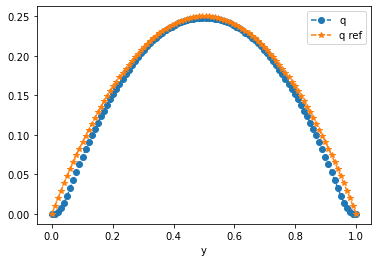

In [109]:
plt.figure()

plt.plot(yy, q_data[-1, :],  "--o", label="q")
plt.plot(yy, q_sol,  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()